### scaling 여부와 scaling 종류에 따른 모델 성능 비교 및

### 각 공정별 상관 높은 변수들의 pca에 따른 모델 성능비교 

In [15]:
!pip install pycaret[full]

  Using cached shap-0.44.1-cp311-cp311-win_amd64.whl.metadata (25 kB)
  Using cached interpret-0.6.3-py3-none-any.whl.metadata (1.1 kB)
  Using cached umap_learn-0.5.6-py3-none-any.whl.metadata (21 kB)
  Using cached ydata_profiling-4.9.0-py2.py3-none-any.whl.metadata (20 kB)
  Using cached explainerdashboard-0.4.7-py3-none-any.whl.metadata (3.8 kB)
  Using cached fairlearn-0.7.0-py3-none-any.whl.metadata (7.3 kB)
  Using cached kmodes-0.12.2-py2.py3-none-any.whl.metadata (8.1 kB)
  Using cached mlxtend-0.23.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached statsforecast-1.5.0-py3-none-any.whl.metadata (23 kB)
  Using cached hyperopt-0.2.7-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached optuna_integration-3.6.0-py3-none-any.whl.metadata (10 kB)
  Using cached scikit_optimize-0.10.2-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached mlflow-2.15.1-py3-none-any.whl.metadata (29 kB)
  Using cached gradio-4.42.0-py3-none-any.whl.metadata (15 kB)
  Using cached uvicorn-0.30.6-py3-

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.75 requires requests_mock, which is not installed.
aiobotocore 2.7.0 requires botocore<1.31.65,>=1.31.16, but you have botocore 1.35.7 which is incompatible.
anaconda-cloud-auth 0.1.4 requires pydantic<2.0, but you have pydantic 2.8.2 which is incompatible.
conda-repo-cli 1.0.75 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.75 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
s3fs 2023.10.0 requires fsspec==2023.10.0, but you have fsspec 2024.6.1 which is incompatible.


In [44]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.ensemble import BalancedRandomForestClassifier
import optuna
import numpy as np

In [45]:
import os
import warnings
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    make_scorer
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore') # Suppress warnings

In [46]:
RANDOM_STATE = 110

# Load data
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

### workerorder_Dam 처리

In [47]:
# Load data
RANDOM_STATE = 110

# 타겟 변수 변환: 'AbNormal' -> 1, 'Normal' -> 0
train_data['target'] = train_data['target'].map({'AbNormal': 1, 'Normal': 0})

# ID 변수 클렌징
train_data['Workorder_Dam'] = train_data['Workorder_Dam'].astype(str).str.strip()
test_data['Workorder_Dam'] = test_data['Workorder_Dam'].astype(str).str.strip()

# KFold 교차 검증 및 Mean Encoding 적용
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
encoded_values = np.zeros(len(train_data))

for train_idx, val_idx in kf.split(train_data):
    X_train, X_val = train_data.iloc[train_idx], train_data.iloc[val_idx]
    y_train = train_data['target'].iloc[train_idx]

    # 각 폴드에서 train data를 사용해 mean encoding 계산
    means = X_train.groupby('Workorder_Dam')['target'].mean()
    
    # 검증 데이터에 mean encoding 적용
    encoded_values[val_idx] = X_val['Workorder_Dam'].map(means)

train_data['Workorder_Dam_encoded'] = encoded_values

# 테스트 데이터는 전체 train 데이터의 평균을 사용해 인코딩
means = train_data.groupby('Workorder_Dam')['target'].mean()
test_data['Workorder_Dam_encoded'] = test_data['Workorder_Dam'].map(means).fillna(train_data['target'].mean())

# 타겟 변수를 원래대로 복원: 1 -> 'AbNormal', 0 -> 'Normal'
train_data['target'] = train_data['target'].map({1: 'AbNormal', 0: 'Normal'})

In [48]:
train_data['Workorder_Dam_encoded']

0        0.180723
1        0.020000
2        0.012195
3        0.064103
4        0.090909
           ...   
40501    0.038462
40502    0.018868
40503    0.035714
40504    0.035088
40505    0.129630
Name: Workorder_Dam_encoded, Length: 40506, dtype: float64

In [49]:
train_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'].replace('OK', 1, inplace=True)
test_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'].replace('OK', 1, inplace=True)

In [50]:
train_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'].fillna(0, inplace=True)
test_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'].fillna(0, inplace=True)

In [ ]:
HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam
THICKNESS 1 Collect Result_Dam
Workorder_Dam_encoded
Production Qty Collect Result_Dam


In [51]:
train_split_df, valid_df = train_test_split(
    train_data,
    test_size=0.2,
    stratify=train_data["target"],
    random_state=RANDOM_STATE,
)



In [52]:
y_train = train_split_df['target']
X_train = train_split_df.drop('target', axis=1)

# 결과 확인
print(X_train.shape)
print(y_train.value_counts())

(32404, 464)
target
Normal      30524
AbNormal     1880
Name: count, dtype: int64


In [53]:
y_valid = valid_df['target']
X_valid = valid_df.drop('target', axis=1)

# 결과 확인
print(X_valid.shape)
print(y_valid.value_counts())

(8102, 464)
target
Normal      7632
AbNormal     470
Name: count, dtype: int64


In [54]:
X_train

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION X Unit Time_Dam,CURE END POSITION X Judge Value_Dam,...,Production Qty Collect Result_Fill2,Production Qty Unit Time_Fill2,Production Qty Judge Value_Fill2,Receip No Collect Result_Fill2,Receip No Unit Time_Fill2,Receip No Judge Value_Fill2,WorkMode Collect Result_Fill2,WorkMode Unit Time_Fill2,WorkMode Judge Value_Fill2,Workorder_Dam_encoded
24811,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3G1XA501-1,1,OK,240.0,NaN,NaN,...,330,NaN,NaN,1,NaN,NaN,0,NaN,NaN,0.142857
12549,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3G1XD204-1,1,OK,240.0,NaN,NaN,...,8,NaN,NaN,1,NaN,NaN,0,NaN,NaN,0.058824
4956,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3L1XA128-1,1,OK,240.0,NaN,NaN,...,205,NaN,NaN,1,NaN,NaN,0,NaN,NaN,0.007752
1781,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334505,4E1XB382-1,1,OK,1000.0,NaN,NaN,...,130,NaN,NaN,1,NaN,NaN,0,NaN,NaN,0.000000
35415,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1XA548-1,1,OK,1000.0,NaN,NaN,...,13,NaN,NaN,1,NaN,NaN,0,NaN,NaN,0.088235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5856,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3H1X7976-1,1,OK,240.0,NaN,NaN,...,19,NaN,NaN,1,NaN,NaN,0,NaN,NaN,0.025000
12026,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1X9167-1,1,OK,1000.0,NaN,NaN,...,152,NaN,NaN,1,NaN,NaN,0,NaN,NaN,0.011494
13286,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X9648-1,1,OK,240.0,NaN,NaN,...,192,NaN,NaN,1,NaN,NaN,0,NaN,NaN,0.069231
1593,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3L1XB019-1,1,OK,1000.0,NaN,NaN,...,28,NaN,NaN,1,NaN,NaN,0,NaN,NaN,0.023810


In [55]:
y_train

24811    Normal
12549    Normal
4956     Normal
1781     Normal
35415    Normal
          ...  
5856     Normal
12026    Normal
13286    Normal
1593     Normal
12593    Normal
Name: target, Length: 32404, dtype: object

## 모델링

In [13]:
def my_tune_model(model_name, fold, n_iter, optimize):
  m = create_model(model_name, fold = kfold)
  return tune_model(m, fold = kfold, n_iter = n_iter, optimize = optimize)

In [23]:
# Step 1: 특정 변수 선택
selected_features = ['Workorder_Dam_encoded', 'Production Qty Collect Result_Dam', 
                     'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam','THICKNESS 1 Collect Result_Dam']  # 스케일링할 변수들
X_train_features = X_train[selected_features]
X_train_features

,Workorder_Dam_encoded,Production Qty Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,THICKNESS 1 Collect Result_Dam
24811,0.142857,330,377.5,0.000
12549,0.058824,8,377.5,0.000
4956,0.007752,205,377.6,0.000
1781,0.000000,130,1271.8,-0.015
35415,0.088235,13,1271.8,-0.015
...,...,...,...,...
5856,0.025000,19,377.3,0.000
12026,0.011494,152,1271.8,0.000
13286,0.069231,192,377.5,0.000
1593,0.023810,28,1271.8,0.000


In [15]:
clf = setup(data = X_train_features, target = y_train, session_id = RANDOM_STATE)
models = compare_models(sort = 'F1', n_select = 10)

kfold = 5  # kfold 값을 5로 변경

def my_tune_model(model_name, fold, n_iter, optimize):
  m = create_model(model_name, fold = kfold)
  return tune_model(m, fold = kfold, n_iter = n_iter, optimize = optimize)


model_list = []
#for model_name in ['catboost', 'rf', 'et', 'lightgbm', 'xgboost', 'gbc', 'ada', 'knn', 'lda']:
for model_name in ['catboost', 'rf', 'et', 'lightgbm', 'xgboost']:
  model_list.append(my_tune_model(model_name, fold = kfold, n_iter = 5, optimize = 'F1'))  # n_iter 값을 5로 변경

blended_model = blend_models(estimator_list = model_list,
                       fold = kfold,
                       method = 'soft',
                       optimize='F1'
                       )

from sklearn.metrics import f1_score
y_pred = predict_model(blended_model, data = X_valid)
thresholds = np.arange(0.50, 1.00, 0.01)

f1_scores = []

for threshold in thresholds:
    # 임계값을 기준으로 라벨 생성
    y_valid_pred = ['Normal' if score >= threshold else 'AbNormal' for score in y_pred['prediction_score']]

    # F1 스코어 계산
    f1 = f1_score(y_valid, y_valid_pred, pos_label='AbNormal')
    f1_scores.append((threshold, f1))

# 결과 출력
for threshold, f1 in f1_scores:
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")


,Description,Value
0,Session id,110
1,Target,target
2,Target type,Binary
3,Target mapping,"AbNormal: 0, Normal: 1"
4,Original data shape,"(32404, 5)"
5,Transformed data shape,"(32404, 5)"
6,Transformed train set shape,"(22682, 5)"
7,Transformed test set shape,"(9722, 5)"
8,Numeric features,4
9,Rows with missing values,0.0%


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9428,0.6333,0.9428,0.9232,0.9196,0.0846,0.1578,0.2540
catboost,CatBoost Classifier,0.9436,0.6583,0.9436,0.9328,0.9193,0.0754,0.1681,11.4480
lightgbm,Light Gradient Boosting Machine,0.9434,0.6489,0.9434,0.9334,0.9190,0.0715,0.1640,0.6550
gbc,Gradient Boosting Classifier,0.9434,0.6632,0.9434,0.9365,0.9183,0.0608,0.1573,0.9760
lda,Linear Discriminant Analysis,0.9400,0.6528,0.9400,0.9107,0.9174,0.0688,0.1119,0.1010
rf,Random Forest Classifier,0.9340,0.6087,0.9340,0.9073,0.9173,0.1072,0.1275,1.3540
lr,Logistic Regression,0.9426,0.6521,0.9426,0.9321,0.9160,0.0301,0.1024,0.6530
ridge,Ridge Classifier,0.9426,0.6529,0.9426,0.9320,0.9159,0.0287,0.0989,0.1050
nb,Naive Bayes,0.9312,0.6162,0.9312,0.9044,0.9153,0.0946,0.1087,0.0990
ada,Ada Boost Classifier,0.9421,0.6533,0.9421,0.9151,0.9153,0.0224,0.0693,0.4460


Processing:   0%|          | 0/78 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9438,0.6561,0.9438,0.9413,0.9186,0.0620,0.1694
1,0.9440,0.6345,0.9440,0.9368,0.9200,0.0868,0.1917
2,0.9433,0.6756,0.9433,0.9307,0.9187,0.0667,0.1563
3,0.9433,0.6702,0.9433,0.9276,0.9198,0.0844,0.1686
4,0.9438,0.6430,0.9438,0.9351,0.9193,0.0740,0.1733
Mean,0.9437,0.6559,0.9437,0.9343,0.9193,0.0748,0.1718
Std,0.0003,0.0156,0.0003,0.0048,0.0006,0.0097,0.0115


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9431,0.6596,0.9431,0.9311,0.9178,0.0540,0.1412
1,0.9442,0.6374,0.9442,0.9376,0.9205,0.0933,0.2005
2,0.9438,0.6859,0.9438,0.9377,0.9189,0.0680,0.1709
3,0.9444,0.6605,0.9444,0.9402,0.9204,0.0878,0.1993
4,0.9436,0.6449,0.9436,0.9320,0.9192,0.0733,0.1665
Mean,0.9438,0.6577,0.9438,0.9357,0.9194,0.0753,0.1757
Std,0.0005,0.0166,0.0005,0.0035,0.0010,0.0141,0.0222


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9350,0.6171,0.9350,0.9024,0.9150,0.0613,0.0809
1,0.9332,0.6222,0.9332,0.9050,0.9159,0.0923,0.1109
2,0.9345,0.6350,0.9345,0.9094,0.9186,0.1240,0.1453
3,0.9343,0.5974,0.9343,0.9087,0.9182,0.1187,0.1396
4,0.9374,0.5843,0.9374,0.9109,0.9192,0.1138,0.1447
Mean,0.9349,0.6112,0.9349,0.9073,0.9174,0.1020,0.1243
Std,0.0014,0.0181,0.0014,0.0031,0.0016,0.0230,0.0251


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
1,0.9418,0.5000,0.9418,0.8870,0.9136,0.0000,0.0000
2,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
3,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
4,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
Mean,0.9420,0.5000,0.9420,0.8873,0.9138,0.0000,0.0000
Std,0.0001,0.0000,0.0001,0.0002,0.0001,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9244,0.6102,0.9244,0.9004,0.9112,0.0751,0.0812
1,0.9171,0.6036,0.9171,0.9011,0.9086,0.0923,0.0947
2,0.9191,0.6147,0.9191,0.9011,0.9095,0.0886,0.0918
3,0.9178,0.5860,0.9178,0.9020,0.9094,0.0975,0.1000
4,0.9244,0.5633,0.9244,0.9023,0.9122,0.0924,0.0987
Mean,0.9206,0.5956,0.9206,0.9014,0.9102,0.0892,0.0933
Std,0.0032,0.0189,0.0032,0.0007,0.0013,0.0076,0.0067


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
1,0.9418,0.5000,0.9418,0.8870,0.9136,0.0000,0.0000
2,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
3,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
4,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
Mean,0.9420,0.5000,0.9420,0.8873,0.9138,0.0000,0.0000
Std,0.0001,0.0000,0.0001,0.0002,0.0001,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9434,0.6515,0.9434,0.9353,0.9179,0.0546,0.1492
1,0.9442,0.6371,0.9442,0.9400,0.9201,0.0875,0.1989
2,0.9438,0.6727,0.9438,0.9377,0.9189,0.0680,0.1709
3,0.9436,0.6455,0.9436,0.9306,0.9196,0.0792,0.1700
4,0.9433,0.6378,0.9433,0.9307,0.9187,0.0667,0.1563
Mean,0.9437,0.6489,0.9437,0.9349,0.9190,0.0712,0.1691
Std,0.0003,0.0130,0.0003,0.0037,0.0008,0.0113,0.0170


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9436,0.6466,0.9436,0.9468,0.9176,0.0490,0.1585
1,0.9429,0.6413,0.9429,0.9309,0.9175,0.0538,0.1409
2,0.9427,0.6801,0.9427,0.9298,0.9163,0.0341,0.1104
3,0.9436,0.6363,0.9436,0.9405,0.9180,0.0552,0.1585
4,0.9429,0.6395,0.9429,0.9367,0.9165,0.0347,0.1207
Mean,0.9431,0.6488,0.9431,0.9369,0.9172,0.0454,0.1378
Std,0.0004,0.0160,0.0004,0.0063,0.0007,0.0092,0.0195


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9423,0.6386,0.9423,0.9199,0.9169,0.0455,0.1102
1,0.9438,0.6185,0.9438,0.9340,0.9199,0.0861,0.1851
2,0.9431,0.6425,0.9431,0.9253,0.9200,0.0894,0.1682
3,0.9425,0.6218,0.9425,0.9213,0.9186,0.0701,0.1401
4,0.9431,0.6150,0.9431,0.9258,0.9197,0.0837,0.1637
Mean,0.9430,0.6273,0.9430,0.9253,0.9190,0.0750,0.1535
Std,0.0005,0.0111,0.0005,0.0049,0.0012,0.0161,0.0260


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9418,0.5896,0.9418,0.9153,0.9163,0.0382,0.0926
1,0.9423,0.5888,0.9423,0.9212,0.9179,0.0640,0.1341
2,0.9414,0.6182,0.9414,0.9133,0.9168,0.0493,0.1008
3,0.9427,0.5912,0.9427,0.9230,0.9187,0.0708,0.1446
4,0.9429,0.5595,0.9429,0.9249,0.9188,0.0714,0.1494
Mean,0.9422,0.5895,0.9422,0.9195,0.9177,0.0587,0.1243
Std,0.0006,0.0186,0.0006,0.0045,0.0010,0.0130,0.0232


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9434,0.6574,0.9434,0.9395,0.9175,0.0484,0.1469
1,0.9438,0.6417,0.9438,0.9419,0.9187,0.0684,0.1792
2,0.9440,0.6706,0.9440,0.9421,0.9191,0.0687,0.1796
3,0.9442,0.6415,0.9442,0.9394,0.9199,0.0813,0.1903
4,0.9438,0.6282,0.9438,0.9351,0.9193,0.0740,0.1733
Mean,0.9438,0.6479,0.9438,0.9396,0.9189,0.0681,0.1738
Std,0.0003,0.0146,0.0003,0.0025,0.0008,0.0109,0.0145


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Threshold: 0.50, F1 Score: 0.0000
Threshold: 0.51, F1 Score: 0.0042
Threshold: 0.52, F1 Score: 0.0085
Threshold: 0.53, F1 Score: 0.0126
Threshold: 0.54, F1 Score: 0.0167
Threshold: 0.55, F1 Score: 0.0166
Threshold: 0.56, F1 Score: 0.0207
Threshold: 0.57, F1 Score: 0.0247
Threshold: 0.58, F1 Score: 0.0246
Threshold: 0.59, F1 Score: 0.0327
Threshold: 0.60, F1 Score: 0.0327
Threshold: 0.61, F1 Score: 0.0325
Threshold: 0.62, F1 Score: 0.0325
Threshold: 0.63, F1 Score: 0.0362
Threshold: 0.64, F1 Score: 0.0360
Threshold: 0.65, F1 Score: 0.0360
Threshold: 0.66, F1 Score: 0.0398
Threshold: 0.67, F1 Score: 0.0437
Threshold: 0.68, F1 Score: 0.0437
Threshold: 0.69, F1 Score: 0.0472
Threshold: 0.70, F1 Score: 0.0545
Threshold: 0.71, F1 Score: 0.0618
Threshold: 0.72, F1 Score: 0.0873
Threshold: 0.73, F1 Score: 0.0972
Threshold: 0.74, F1 Score: 0.1037
Threshold: 0.75, F1 Score: 0.1261
Threshold: 0.76, F1 Score: 0.1319
Threshold: 0.77, F1 Score: 0.1562
Threshold: 0.78, F1 Score: 0.1638
Threshold: 0.7

## 표준화 sclaing

In [18]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score


In [24]:
X_train_baseline = X_train.copy()
# Step 2: 스케일링 적용
# StandardScaler 적용
scaler_standard = StandardScaler()
X_train_standard_scaled = X_train_baseline.copy()
X_train_standard_scaled[selected_features] = scaler_standard.fit_transform(X_train_baseline[selected_features])
X_scaled_features = X_train_standard_scaled[selected_features]
X_scaled_features

,Workorder_Dam_encoded,Production Qty Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,THICKNESS 1 Collect Result_Dam
24811,1.353515,1.290079,-0.784257,0.178381
12549,0.011624,-1.425787,-0.784257,0.178381
4956,-0.803913,0.235783,-0.784027,0.178381
1781,-0.927699,-0.396794,1.275385,-1.398566
35415,0.481286,-1.383615,1.275385,-1.398566
...,...,...,...,...
5856,-0.528487,-1.333009,-0.784718,0.178381
12026,-0.744153,-0.211238,1.275385,0.178381
13286,0.177812,0.126136,-0.784257,0.178381
1593,-0.547497,-1.257100,1.275385,0.178381


## 모델링

In [20]:
clf = setup(data = X_scaled_features, target = y_train, session_id = RANDOM_STATE)
models = compare_models(sort = 'F1', n_select = 10)

kfold = 5  # kfold 값을 5로 변경

def my_tune_model(model_name, fold, n_iter, optimize):
  m = create_model(model_name, fold = kfold)
  return tune_model(m, fold = kfold, n_iter = n_iter, optimize = optimize)


model_list = []
#for model_name in ['catboost', 'rf', 'et', 'lightgbm', 'xgboost', 'gbc', 'ada', 'knn', 'lda']:
for model_name in ['catboost', 'rf', 'et', 'lightgbm', 'xgboost']:
  model_list.append(my_tune_model(model_name, fold = kfold, n_iter = 5, optimize = 'F1'))  # n_iter 값을 5로 변경

blended_model = blend_models(estimator_list = model_list,
                       fold = kfold,
                       method = 'soft',
                       optimize='F1'
                       )

from sklearn.metrics import f1_score
y_pred = predict_model(blended_model, data = X_valid)
thresholds = np.arange(0.50, 1.00, 0.01)

f1_scores = []

for threshold in thresholds:
    # 임계값을 기준으로 라벨 생성
    y_valid_pred = ['Normal' if score >= threshold else 'AbNormal' for score in y_pred['prediction_score']]

    # F1 스코어 계산
    f1 = f1_score(y_valid, y_valid_pred, pos_label='AbNormal')
    f1_scores.append((threshold, f1))

# 결과 출력
for threshold, f1 in f1_scores:
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")

,Description,Value
0,Session id,110
1,Target,target
2,Target type,Binary
3,Target mapping,"AbNormal: 0, Normal: 1"
4,Original data shape,"(32404, 5)"
5,Transformed data shape,"(32404, 5)"
6,Transformed train set shape,"(22682, 5)"
7,Transformed test set shape,"(9722, 5)"
8,Numeric features,4
9,Rows with missing values,0.0%


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9428,0.6333,0.9428,0.9232,0.9196,0.0846,0.1578,0.2490
catboost,CatBoost Classifier,0.9436,0.6583,0.9436,0.9328,0.9193,0.0754,0.1681,11.6830
lightgbm,Light Gradient Boosting Machine,0.9434,0.6522,0.9434,0.9331,0.9189,0.0701,0.1611,0.6990
gbc,Gradient Boosting Classifier,0.9434,0.6632,0.9434,0.9365,0.9183,0.0608,0.1573,1.0550
knn,K Neighbors Classifier,0.9408,0.5741,0.9408,0.9154,0.9181,0.0745,0.1282,0.1030
lr,Logistic Regression,0.9429,0.6516,0.9429,0.9277,0.9178,0.0569,0.1373,0.6460
rf,Random Forest Classifier,0.9343,0.6083,0.9343,0.9077,0.9176,0.1098,0.1307,1.3830
lda,Linear Discriminant Analysis,0.9400,0.6528,0.9400,0.9107,0.9174,0.0688,0.1119,0.1030
ridge,Ridge Classifier,0.9426,0.6528,0.9426,0.9320,0.9159,0.0287,0.0989,0.0990
ada,Ada Boost Classifier,0.9422,0.6534,0.9422,0.9162,0.9154,0.0226,0.0714,0.4540


Processing:   0%|          | 0/78 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9438,0.6561,0.9438,0.9413,0.9186,0.0620,0.1694
1,0.9440,0.6345,0.9440,0.9368,0.9200,0.0868,0.1917
2,0.9433,0.6756,0.9433,0.9307,0.9187,0.0667,0.1563
3,0.9433,0.6702,0.9433,0.9276,0.9198,0.0844,0.1686
4,0.9438,0.6430,0.9438,0.9351,0.9193,0.0740,0.1733
Mean,0.9437,0.6559,0.9437,0.9343,0.9193,0.0748,0.1718
Std,0.0003,0.0156,0.0003,0.0048,0.0006,0.0097,0.0115


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9431,0.6596,0.9431,0.9311,0.9178,0.0540,0.1412
1,0.9442,0.6374,0.9442,0.9376,0.9205,0.0933,0.2005
2,0.9438,0.6859,0.9438,0.9377,0.9189,0.0680,0.1709
3,0.9444,0.6605,0.9444,0.9402,0.9204,0.0878,0.1993
4,0.9436,0.6449,0.9436,0.9320,0.9192,0.0733,0.1665
Mean,0.9438,0.6577,0.9438,0.9357,0.9194,0.0753,0.1757
Std,0.0005,0.0166,0.0005,0.0035,0.0010,0.0141,0.0222


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9350,0.6168,0.9350,0.9032,0.9153,0.0666,0.0869
1,0.9326,0.6219,0.9326,0.9044,0.9155,0.0905,0.1076
2,0.9336,0.6363,0.9336,0.9086,0.9180,0.1213,0.1406
3,0.9350,0.5960,0.9350,0.9094,0.9186,0.1207,0.1433
4,0.9372,0.5826,0.9372,0.9101,0.9188,0.1082,0.1383
Mean,0.9347,0.6107,0.9347,0.9071,0.9172,0.1015,0.1233
Std,0.0015,0.0191,0.0015,0.0028,0.0015,0.0207,0.0223


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
1,0.9418,0.5000,0.9418,0.8870,0.9136,0.0000,0.0000
2,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
3,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
4,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
Mean,0.9420,0.5000,0.9420,0.8873,0.9138,0.0000,0.0000
Std,0.0001,0.0000,0.0001,0.0002,0.0001,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9244,0.6103,0.9244,0.9004,0.9112,0.0751,0.0812
1,0.9171,0.6036,0.9171,0.9011,0.9086,0.0923,0.0947
2,0.9191,0.6147,0.9191,0.9011,0.9095,0.0886,0.0918
3,0.9178,0.5860,0.9178,0.9020,0.9094,0.0975,0.1000
4,0.9244,0.5633,0.9244,0.9023,0.9122,0.0924,0.0987
Mean,0.9206,0.5956,0.9206,0.9014,0.9102,0.0892,0.0933
Std,0.0032,0.0189,0.0032,0.0007,0.0013,0.0076,0.0067


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
1,0.9418,0.5000,0.9418,0.8870,0.9136,0.0000,0.0000
2,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
3,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
4,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
Mean,0.9420,0.5000,0.9420,0.8873,0.9138,0.0000,0.0000
Std,0.0001,0.0000,0.0001,0.0002,0.0001,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9434,0.6532,0.9434,0.9395,0.9175,0.0484,0.1469
1,0.9436,0.6341,0.9436,0.9330,0.9194,0.0796,0.1758
2,0.9433,0.6706,0.9433,0.9307,0.9187,0.0667,0.1563
3,0.9433,0.6484,0.9433,0.9283,0.9194,0.0786,0.1644
4,0.9429,0.6319,0.9429,0.9264,0.9180,0.0595,0.1392
Mean,0.9433,0.6476,0.9433,0.9316,0.9186,0.0666,0.1565
Std,0.0002,0.0141,0.0002,0.0045,0.0007,0.0118,0.0128


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9434,0.6521,0.9434,0.9395,0.9175,0.0484,0.1469
1,0.9427,0.6302,0.9427,0.9291,0.9170,0.0470,0.1289
2,0.9433,0.6686,0.9433,0.9326,0.9183,0.0607,0.1525
3,0.9440,0.6385,0.9440,0.9421,0.9191,0.0687,0.1796
4,0.9431,0.6410,0.9431,0.9383,0.9170,0.0416,0.1344
Mean,0.9433,0.6461,0.9433,0.9363,0.9178,0.0533,0.1485
Std,0.0004,0.0132,0.0004,0.0048,0.0008,0.0099,0.0177


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9423,0.6386,0.9423,0.9199,0.9169,0.0455,0.1102
1,0.9438,0.6185,0.9438,0.9340,0.9199,0.0861,0.1851
2,0.9431,0.6425,0.9431,0.9253,0.9200,0.0894,0.1682
3,0.9425,0.6218,0.9425,0.9213,0.9186,0.0701,0.1401
4,0.9431,0.6150,0.9431,0.9258,0.9197,0.0837,0.1637
Mean,0.9430,0.6273,0.9430,0.9253,0.9190,0.0750,0.1535
Std,0.0005,0.0111,0.0005,0.0049,0.0012,0.0161,0.0260


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9418,0.5896,0.9418,0.9153,0.9163,0.0382,0.0926
1,0.9423,0.5888,0.9423,0.9212,0.9179,0.0640,0.1341
2,0.9414,0.6182,0.9414,0.9133,0.9168,0.0493,0.1008
3,0.9427,0.5912,0.9427,0.9230,0.9187,0.0708,0.1446
4,0.9429,0.5595,0.9429,0.9249,0.9188,0.0714,0.1494
Mean,0.9422,0.5895,0.9422,0.9195,0.9177,0.0587,0.1243
Std,0.0006,0.0186,0.0006,0.0045,0.0010,0.0130,0.0232


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9436,0.6578,0.9436,0.9468,0.9176,0.0490,0.1585
1,0.9438,0.6389,0.9438,0.9419,0.9187,0.0684,0.1792
2,0.9438,0.6708,0.9438,0.9413,0.9185,0.0619,0.1694
3,0.9442,0.6413,0.9442,0.9394,0.9199,0.0813,0.1903
4,0.9438,0.6269,0.9438,0.9351,0.9193,0.0740,0.1733
Mean,0.9438,0.6471,0.9438,0.9409,0.9188,0.0669,0.1741
Std,0.0002,0.0154,0.0002,0.0038,0.0008,0.0110,0.0105


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Threshold: 0.50, F1 Score: 0.0000
Threshold: 0.51, F1 Score: 0.0000
Threshold: 0.52, F1 Score: 0.0000
Threshold: 0.53, F1 Score: 0.0000
Threshold: 0.54, F1 Score: 0.0000
Threshold: 0.55, F1 Score: 0.0000
Threshold: 0.56, F1 Score: 0.0000
Threshold: 0.57, F1 Score: 0.0000
Threshold: 0.58, F1 Score: 0.0000
Threshold: 0.59, F1 Score: 0.0000
Threshold: 0.60, F1 Score: 0.0335
Threshold: 0.61, F1 Score: 0.0335
Threshold: 0.62, F1 Score: 0.0335
Threshold: 0.63, F1 Score: 0.0335
Threshold: 0.64, F1 Score: 0.0335
Threshold: 0.65, F1 Score: 0.0335
Threshold: 0.66, F1 Score: 0.0335
Threshold: 0.67, F1 Score: 0.0335
Threshold: 0.68, F1 Score: 0.0335
Threshold: 0.69, F1 Score: 0.0335
Threshold: 0.70, F1 Score: 0.0335
Threshold: 0.71, F1 Score: 0.0335
Threshold: 0.72, F1 Score: 0.0335
Threshold: 0.73, F1 Score: 0.0536
Threshold: 0.74, F1 Score: 0.0536
Threshold: 0.75, F1 Score: 0.0613
Threshold: 0.76, F1 Score: 0.0652
Threshold: 0.77, F1 Score: 0.0652
Threshold: 0.78, F1 Score: 0.0652
Threshold: 0.7

## min max scaling

In [25]:
# MinMaxScaler 적용
scaler_minmax = MinMaxScaler()
X_train_minmax_scaled = X_train_baseline.copy()
X_train_minmax_scaled[selected_features] = scaler_minmax.fit_transform(X_train_baseline[selected_features])
X_minmax_features = X_train_minmax_scaled[selected_features]

In [26]:
X_minmax_features

,Workorder_Dam_encoded,Production Qty Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,THICKNESS 1 Collect Result_Dam
24811,0.142857,0.542763,0.000221,0.593407
12549,0.058824,0.013158,0.000221,0.593407
4956,0.007752,0.337171,0.000332,0.593407
1781,0.000000,0.213816,0.988944,0.428571
35415,0.088235,0.021382,0.988944,0.428571
...,...,...,...,...
5856,0.025000,0.031250,0.000000,0.593407
12026,0.011494,0.250000,0.988944,0.593407
13286,0.069231,0.315789,0.000221,0.593407
1593,0.023810,0.046053,0.988944,0.593407


In [27]:
clf = setup(data = X_minmax_features, target = y_train, session_id = RANDOM_STATE)
models = compare_models(sort = 'F1', n_select = 10)

kfold = 5  # kfold 값을 5로 변경

def my_tune_model(model_name, fold, n_iter, optimize):
  m = create_model(model_name, fold = kfold)
  return tune_model(m, fold = kfold, n_iter = n_iter, optimize = optimize)


model_list = []
#for model_name in ['catboost', 'rf', 'et', 'lightgbm', 'xgboost', 'gbc', 'ada', 'knn', 'lda']:
for model_name in ['catboost', 'rf', 'et', 'lightgbm', 'xgboost']:
  model_list.append(my_tune_model(model_name, fold = kfold, n_iter = 5, optimize = 'F1'))  # n_iter 값을 5로 변경

blended_model = blend_models(estimator_list = model_list,
                       fold = kfold,
                       method = 'soft',
                       optimize='F1'
                       )

from sklearn.metrics import f1_score
y_pred = predict_model(blended_model, data = X_valid)
thresholds = np.arange(0.50, 1.00, 0.01)

f1_scores = []

for threshold in thresholds:
    # 임계값을 기준으로 라벨 생성
    y_valid_pred = ['Normal' if score >= threshold else 'AbNormal' for score in y_pred['prediction_score']]

    # F1 스코어 계산
    f1 = f1_score(y_valid, y_valid_pred, pos_label='AbNormal')
    f1_scores.append((threshold, f1))

# 결과 출력
for threshold, f1 in f1_scores:
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")

,Description,Value
0,Session id,110
1,Target,target
2,Target type,Binary
3,Target mapping,"AbNormal: 0, Normal: 1"
4,Original data shape,"(32404, 5)"
5,Transformed data shape,"(32404, 5)"
6,Transformed train set shape,"(22682, 5)"
7,Transformed test set shape,"(9722, 5)"
8,Numeric features,4
9,Rows with missing values,0.0%


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9428,0.6333,0.9428,0.9232,0.9196,0.0846,0.1578,0.2510
catboost,CatBoost Classifier,0.9436,0.6583,0.9436,0.9328,0.9193,0.0754,0.1681,11.5850
lightgbm,Light Gradient Boosting Machine,0.9434,0.6489,0.9434,0.9334,0.9190,0.0715,0.1640,0.5670
gbc,Gradient Boosting Classifier,0.9434,0.6632,0.9434,0.9365,0.9183,0.0608,0.1573,1.0380
knn,K Neighbors Classifier,0.9409,0.5714,0.9409,0.9141,0.9182,0.0746,0.1258,0.9180
lda,Linear Discriminant Analysis,0.9400,0.6528,0.9400,0.9107,0.9174,0.0688,0.1119,0.0970
rf,Random Forest Classifier,0.9338,0.6101,0.9338,0.9070,0.9171,0.1057,0.1256,1.4440
lr,Logistic Regression,0.9426,0.6518,0.9426,0.9321,0.9160,0.0301,0.1024,0.5220
ridge,Ridge Classifier,0.9426,0.6528,0.9426,0.9320,0.9159,0.0287,0.0989,0.1030
nb,Naive Bayes,0.9306,0.6116,0.9306,0.9046,0.9153,0.0979,0.1115,0.0940


Processing:   0%|          | 0/78 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9438,0.6561,0.9438,0.9413,0.9186,0.0620,0.1694
1,0.9440,0.6345,0.9440,0.9368,0.9200,0.0868,0.1917
2,0.9433,0.6756,0.9433,0.9307,0.9187,0.0667,0.1563
3,0.9433,0.6702,0.9433,0.9276,0.9198,0.0844,0.1686
4,0.9438,0.6430,0.9438,0.9351,0.9193,0.0740,0.1733
Mean,0.9437,0.6559,0.9437,0.9343,0.9193,0.0748,0.1718
Std,0.0003,0.0156,0.0003,0.0048,0.0006,0.0097,0.0115


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9431,0.6596,0.9431,0.9311,0.9178,0.0540,0.1412
1,0.9442,0.6374,0.9442,0.9376,0.9205,0.0933,0.2005
2,0.9438,0.6859,0.9438,0.9377,0.9189,0.0680,0.1709
3,0.9444,0.6605,0.9444,0.9402,0.9204,0.0878,0.1993
4,0.9436,0.6449,0.9436,0.9320,0.9192,0.0733,0.1665
Mean,0.9438,0.6577,0.9438,0.9357,0.9194,0.0753,0.1757
Std,0.0005,0.0166,0.0005,0.0035,0.0010,0.0141,0.0222


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9350,0.6168,0.9350,0.9032,0.9153,0.0666,0.0869
1,0.9334,0.6190,0.9334,0.9057,0.9163,0.0977,0.1169
2,0.9336,0.6356,0.9336,0.9086,0.9180,0.1213,0.1406
3,0.9343,0.5993,0.9343,0.9082,0.9179,0.1141,0.1350
4,0.9376,0.5850,0.9376,0.9112,0.9193,0.1145,0.1463
Mean,0.9348,0.6111,0.9348,0.9074,0.9174,0.1028,0.1251
Std,0.0015,0.0174,0.0015,0.0027,0.0014,0.0197,0.0215


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
1,0.9418,0.5000,0.9418,0.8870,0.9136,0.0000,0.0000
2,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
3,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
4,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
Mean,0.9420,0.5000,0.9420,0.8873,0.9138,0.0000,0.0000
Std,0.0001,0.0000,0.0001,0.0002,0.0001,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9244,0.6102,0.9244,0.9004,0.9112,0.0751,0.0812
1,0.9171,0.6036,0.9171,0.9011,0.9086,0.0923,0.0947
2,0.9191,0.6147,0.9191,0.9011,0.9095,0.0886,0.0918
3,0.9178,0.5860,0.9178,0.9020,0.9094,0.0975,0.1000
4,0.9244,0.5633,0.9244,0.9023,0.9122,0.0924,0.0987
Mean,0.9206,0.5956,0.9206,0.9014,0.9102,0.0892,0.0933
Std,0.0032,0.0189,0.0032,0.0007,0.0013,0.0076,0.0067


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
1,0.9418,0.5000,0.9418,0.8870,0.9136,0.0000,0.0000
2,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
3,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
4,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
Mean,0.9420,0.5000,0.9420,0.8873,0.9138,0.0000,0.0000
Std,0.0001,0.0000,0.0001,0.0002,0.0001,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9434,0.6515,0.9434,0.9353,0.9179,0.0546,0.1492
1,0.9442,0.6371,0.9442,0.9400,0.9201,0.0875,0.1989
2,0.9438,0.6727,0.9438,0.9377,0.9189,0.0680,0.1709
3,0.9436,0.6455,0.9436,0.9306,0.9196,0.0792,0.1700
4,0.9433,0.6378,0.9433,0.9307,0.9187,0.0667,0.1563
Mean,0.9437,0.6489,0.9437,0.9349,0.9190,0.0712,0.1691
Std,0.0003,0.0130,0.0003,0.0037,0.0008,0.0113,0.0170


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9436,0.6466,0.9436,0.9468,0.9176,0.0490,0.1585
1,0.9429,0.6413,0.9429,0.9309,0.9175,0.0538,0.1409
2,0.9427,0.6801,0.9427,0.9298,0.9163,0.0341,0.1104
3,0.9436,0.6363,0.9436,0.9405,0.9180,0.0552,0.1585
4,0.9429,0.6395,0.9429,0.9367,0.9165,0.0347,0.1207
Mean,0.9431,0.6488,0.9431,0.9369,0.9172,0.0454,0.1378
Std,0.0004,0.0160,0.0004,0.0063,0.0007,0.0092,0.0195


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9423,0.6386,0.9423,0.9199,0.9169,0.0455,0.1102
1,0.9438,0.6185,0.9438,0.9340,0.9199,0.0861,0.1851
2,0.9431,0.6425,0.9431,0.9253,0.9200,0.0894,0.1682
3,0.9425,0.6218,0.9425,0.9213,0.9186,0.0701,0.1401
4,0.9431,0.6150,0.9431,0.9258,0.9197,0.0837,0.1637
Mean,0.9430,0.6273,0.9430,0.9253,0.9190,0.0750,0.1535
Std,0.0005,0.0111,0.0005,0.0049,0.0012,0.0161,0.0260


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9418,0.5896,0.9418,0.9153,0.9163,0.0382,0.0926
1,0.9423,0.5888,0.9423,0.9212,0.9179,0.0640,0.1341
2,0.9414,0.6182,0.9414,0.9133,0.9168,0.0493,0.1008
3,0.9427,0.5912,0.9427,0.9230,0.9187,0.0708,0.1446
4,0.9429,0.5595,0.9429,0.9249,0.9188,0.0714,0.1494
Mean,0.9422,0.5895,0.9422,0.9195,0.9177,0.0587,0.1243
Std,0.0006,0.0186,0.0006,0.0045,0.0010,0.0130,0.0232


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9434,0.6576,0.9434,0.9395,0.9175,0.0484,0.1469
1,0.9438,0.6399,0.9438,0.9419,0.9187,0.0684,0.1792
2,0.9440,0.6707,0.9440,0.9421,0.9191,0.0687,0.1796
3,0.9440,0.6424,0.9440,0.9386,0.9194,0.0747,0.1808
4,0.9438,0.6281,0.9438,0.9351,0.9193,0.0740,0.1733
Mean,0.9438,0.6478,0.9438,0.9394,0.9188,0.0668,0.1720
Std,0.0002,0.0148,0.0002,0.0025,0.0007,0.0096,0.0128


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Threshold: 0.50, F1 Score: 0.0000
Threshold: 0.51, F1 Score: 0.0000
Threshold: 0.52, F1 Score: 0.0000
Threshold: 0.53, F1 Score: 0.0000
Threshold: 0.54, F1 Score: 0.0000
Threshold: 0.55, F1 Score: 0.0000
Threshold: 0.56, F1 Score: 0.0000
Threshold: 0.57, F1 Score: 0.0000
Threshold: 0.58, F1 Score: 0.0000
Threshold: 0.59, F1 Score: 0.0000
Threshold: 0.60, F1 Score: 0.0000
Threshold: 0.61, F1 Score: 0.0000
Threshold: 0.62, F1 Score: 0.0000
Threshold: 0.63, F1 Score: 0.0000
Threshold: 0.64, F1 Score: 0.0000
Threshold: 0.65, F1 Score: 0.0000
Threshold: 0.66, F1 Score: 0.0000
Threshold: 0.67, F1 Score: 0.0000
Threshold: 0.68, F1 Score: 0.0000
Threshold: 0.69, F1 Score: 0.0042
Threshold: 0.70, F1 Score: 0.0042
Threshold: 0.71, F1 Score: 0.0042
Threshold: 0.72, F1 Score: 0.0121
Threshold: 0.73, F1 Score: 0.0726
Threshold: 0.74, F1 Score: 0.0870
Threshold: 0.75, F1 Score: 0.1071
Threshold: 0.76, F1 Score: 0.1161
Threshold: 0.77, F1 Score: 0.1173
Threshold: 0.78, F1 Score: 0.1244
Threshold: 0.7

### 결론 scaling X

## 변수확인

In [29]:
# 각 열의 첫 번째 행 값 출력
first_row = X_train.iloc[1000]

# 각 변수의 이름과 첫 번째 행의 값을 출력
for column, value in first_row.items():
    print(f"{column}: {value}")

Wip Line_Dam: IVI-OB6
Process Desc._Dam: Dam Dispenser
Equipment_Dam: Dam dispenser #1
Model.Suffix_Dam: AJX75334501
Workorder_Dam: 3L1X9204-1
Insp. Seq No._Dam: 1
Insp Judge Code_Dam: OK
CURE END POSITION X Collect Result_Dam: 240.0
CURE END POSITION X Unit Time_Dam: nan
CURE END POSITION X Judge Value_Dam: nan
CURE END POSITION Z Collect Result_Dam: 2.5
CURE END POSITION Z Unit Time_Dam: nan
CURE END POSITION Z Judge Value_Dam: nan
CURE END POSITION Θ Collect Result_Dam: -90
CURE END POSITION Θ Unit Time_Dam: nan
CURE END POSITION Θ Judge Value_Dam: nan
CURE SPEED Collect Result_Dam: 70
CURE SPEED Unit Time_Dam: nan
CURE SPEED Judge Value_Dam: nan
CURE STANDBY POSITION X Collect Result_Dam: 1150
CURE STANDBY POSITION X Unit Time_Dam: nan
CURE STANDBY POSITION X Judge Value_Dam: nan
CURE STANDBY POSITION Z Collect Result_Dam: 33.5
CURE STANDBY POSITION Z Unit Time_Dam: nan
CURE STANDBY POSITION Z Judge Value_Dam: nan
CURE STANDBY POSITION Θ Collect Result_Dam: 0
CURE STANDBY POSITION 

### 새로운 변수 조합 

# 공정별 pca

## dam 공정 좌표변수 pca

In [33]:
from sklearn.decomposition import PCA
import pandas as pd

# 예를 들어, 'df'라는 데이터프레임에 모든 데이터가 있다고 가정합니다.
# 주어진 변수들만 선택합니다.
selected_columns = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam'
]

# 선택한 변수들로 데이터프레임 구성
X_train_pca_selected = X_train[selected_columns]

# PCA 수행
pca = PCA(n_components=1)  # 주성분 개수를 설정합니다. (예: 2개의 주성분)
pca_result = pca.fit_transform(X_train_pca_selected)

# 결과를 데이터프레임으로 변환 (선택 사항)
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

# PCA 결과 출력
print(pca_df.head())


           PC1
0  -638.283291
1  -638.517113
2  -638.266688
3  1068.818248
4  1068.818248


### 분산 설명력 

Cumulative explained variance ratio:
[0.99870005 0.99994724 0.99999623 0.99999872 0.99999997 1.
 1.         1.         1.        ]
Number of components to explain 95.0% of the variance: 1


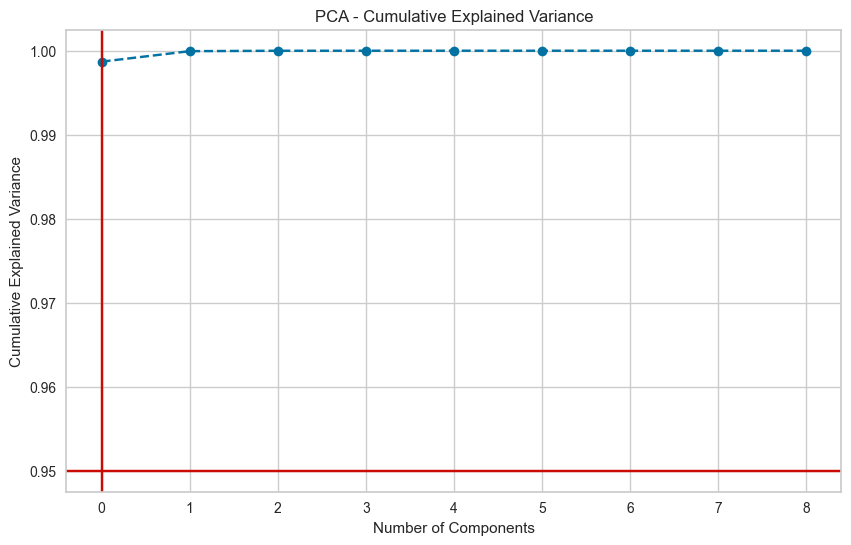

In [32]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# 주어진 변수들로 PCA를 수행할 데이터 선택
X_train_pca_selected = X_train[selected_columns]


# PCA 수행 (모든 주성분 추출)
pca = PCA()
pca.fit(X_train_pca_selected)

# 설명된 분산 비율 계산
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# 누적 설명된 분산 비율 출력
print("Cumulative explained variance ratio:")
print(cumulative_variance_ratio)

# 몇 개의 주성분이 필요할지 결정
desired_variance_explained = 0.95  # 설명하고자 하는 분산 비율 설정 (예: 95%)
num_components = np.argmax(cumulative_variance_ratio >= desired_variance_explained) + 1
print(f"Number of components to explain {desired_variance_explained*100}% of the variance: {num_components}")

# 시각화 (선택 사항)
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.axhline(y=desired_variance_explained, color='r', linestyle='-')
plt.axvline(x=num_components - 1, color='r', linestyle='-')
plt.show()


**주성분 한 개 만으로도 설명력 90% 이상**

### 새로운 변수추가하고 모델확인

In [61]:
from sklearn.decomposition import PCA
import pandas as pd

# 예를 들어, 'df'라는 데이터프레임에 모든 데이터가 있다고 가정합니다.
# 주어진 변수들만 선택합니다.
selected_columns = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam'
]

# 선택한 변수들로 데이터프레임 구성
X_train_pca_selected = X_train[selected_columns]

# PCA 수행
pca = PCA(n_components=1)  # 첫 번째 주성분만 추출
pca_result = pca.fit_transform(X_train_pca_selected)

# PCA 결과를 데이터프레임으로 변환
pca_df = pd.DataFrame(pca_result, columns=['PC1'])

# 기존 X_train을 복사하여 새로운 데이터프레임 생성
X_train_with_pc1 = X_train.copy()

# 복사된 데이터프레임에 PC1 열 추가
X_train_with_pc1['PC1'] = pca_df['PC1']

# PCA 결과가 추가된 데이터프레임 출력
print(X_train_with_pc1.head())


      Wip Line_Dam Process Desc._Dam     Equipment_Dam Model.Suffix_Dam  \
24811      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
12549      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
4956       IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
1781       IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
35415      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   

      Workorder_Dam  Insp. Seq No._Dam Insp Judge Code_Dam  \
24811    3G1XA501-1                  1                  OK   
12549    3G1XD204-1                  1                  OK   
4956     3L1XA128-1                  1                  OK   
1781     4E1XB382-1                  1                  OK   
35415    4E1XA548-1                  1                  OK   

       CURE END POSITION X Collect Result_Dam  \
24811                                   240.0   
12549                                   240.0   
4956                         

In [62]:
value_counts = X_train_with_pc1['PC1'].value_counts(normalize=True, dropna=False) * 100

# 결과 출력
print(value_counts.to_string())

PC1
 NaN            19.886434
-638.283291      9.582150
-638.547485      4.696951
-638.546378      4.206271
 1004.415673     4.098259
 1004.375420     3.872979
-638.248127      2.919393
 1068.787748     2.919393
-638.266688      2.768177
-638.517113      2.567584
-638.340659      2.444143
 999.957501      2.166399
 1003.719138     2.141711
-638.004463      1.604740
-638.008562      1.598568
-638.514636      1.573880
-627.983114      1.558450
 1068.811977     1.558450
-638.243685      1.546105
 1068.812388     1.543019
 1068.792329     1.438094
-638.399878      1.348599
 1084.265428     1.070855
-638.264914      1.015307
-638.405595      0.987532
 1068.818248     0.978274
 1068.788640     0.962844
-638.247374      0.925812
-638.283615      0.882607
-638.515268      0.879521
-638.250224      0.827058
-638.250553      0.827058
 1068.813020     0.771510
 1068.785101     0.749907
 999.843646      0.749907
-638.009763      0.734477
-638.006664      0.725219
 1068.785436     0.626466
 1068.81

## 모델링을 위한 새로운 변수넣고 확인

In [38]:
selected_features = ['Workorder_Dam_encoded', 'Production Qty Collect Result_Dam', 
                     'PC1','THICKNESS 1 Collect Result_Dam']  
X_train_pca = X_train_with_pc1[selected_features]
X_train_pca

,Workorder_Dam_encoded,Production Qty Collect Result_Dam,PC1,THICKNESS 1 Collect Result_Dam
24811,0.142857,330,1004.375420,0.000
12549,0.058824,8,-638.283291,0.000
4956,0.007752,205,1068.811977,0.000
1781,0.000000,130,1068.787748,-0.015
35415,0.088235,13,NaN,-0.015
...,...,...,...,...
5856,0.025000,19,1068.787748,0.000
12026,0.011494,152,-638.250553,0.000
13286,0.069231,192,-638.517113,0.000
1593,0.023810,28,-638.248127,0.000


In [39]:
# NaN 값 처리 (평균으로 대체)
X_train_pca['PC1'].fillna(X_train_pca['PC1'].mean(), inplace=True)


In [43]:
clf = setup(data = X_train_pca, target = y_train, session_id = RANDOM_STATE)
models = compare_models(sort = 'F1', n_select = 10)

kfold = 10  # kfold 값을 5로 변경

def my_tune_model(model_name, fold, n_iter, optimize):
  m = create_model(model_name, fold = kfold)
  return tune_model(m, fold = kfold, n_iter = n_iter, optimize = optimize)


model_list = []
#for model_name in ['catboost', 'rf', 'et', 'lightgbm', 'xgboost', 'gbc', 'ada', 'knn', 'lda']:
for model_name in ['catboost', 'rf', 'et', 'lightgbm', 'xgboost']:
  model_list.append(my_tune_model(model_name, fold = kfold, n_iter = 10, optimize = 'F1'))  # n_iter 값을 5로 변경

blended_model = blend_models(estimator_list = model_list,
                       fold = kfold,
                       method = 'soft',
                       optimize='F1'
                       )

from sklearn.metrics import f1_score
y_pred = predict_model(blended_model, data = X_valid_pca)
thresholds = np.arange(0.50, 1.00, 0.01)

f1_scores = []

for threshold in thresholds:
    # 임계값을 기준으로 라벨 생성
    y_valid_pred = ['Normal' if score >= threshold else 'AbNormal' for score in y_pred['prediction_score']]

    # F1 스코어 계산
    f1 = f1_score(y_valid, y_valid_pred, pos_label='AbNormal')
    f1_scores.append((threshold, f1))

# 결과 출력
for threshold, f1 in f1_scores:
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")

,Description,Value
0,Session id,110
1,Target,target
2,Target type,Binary
3,Target mapping,"AbNormal: 0, Normal: 1"
4,Original data shape,"(32404, 5)"
5,Transformed data shape,"(32404, 5)"
6,Transformed train set shape,"(22682, 5)"
7,Transformed test set shape,"(9722, 5)"
8,Numeric features,4
9,Rows with missing values,0.0%


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9426,0.6075,0.9426,0.9224,0.9188,0.0738,0.1453,0.1010
gbc,Gradient Boosting Classifier,0.9434,0.6522,0.9434,0.9376,0.9181,0.0583,0.1551,0.3320
lightgbm,Light Gradient Boosting Machine,0.9428,0.6338,0.9428,0.9278,0.9178,0.0568,0.1374,0.3110
catboost,CatBoost Classifier,0.9426,0.6298,0.9426,0.9229,0.9177,0.0572,0.1288,4.2890
lda,Linear Discriminant Analysis,0.9399,0.6523,0.9399,0.9103,0.9173,0.0675,0.1098,0.0370
rf,Random Forest Classifier,0.9389,0.6088,0.9389,0.9081,0.9172,0.0713,0.1065,0.5160
lr,Logistic Regression,0.9426,0.6516,0.9426,0.9321,0.9160,0.0301,0.1024,0.8980
ridge,Ridge Classifier,0.9426,0.6525,0.9426,0.9320,0.9159,0.0287,0.0989,0.0430
nb,Naive Bayes,0.9334,0.6182,0.9334,0.9044,0.9157,0.0853,0.1032,0.0310
ada,Ada Boost Classifier,0.9423,0.6396,0.9423,0.9261,0.9156,0.0255,0.0853,0.1590


Processing:   0%|          | 0/78 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9414,0.6574,0.9414,0.9110,0.9151,0.0251,0.0686
1,0.9423,0.5969,0.9423,0.9218,0.9171,0.0520,0.1220
2,0.9449,0.6209,0.9449,0.9371,0.9220,0.1062,0.2117
3,0.9427,0.6065,0.9427,0.9223,0.9177,0.0524,0.1225
4,0.9418,0.6531,0.9418,0.9149,0.9172,0.0501,0.1046
5,0.9422,0.6435,0.9422,0.9182,0.9175,0.0512,0.1128
6,0.9427,0.6703,0.9427,0.9242,0.9189,0.0769,0.1540
7,0.9414,0.6235,0.9414,0.9110,0.9150,0.0251,0.0686
8,0.9422,0.6207,0.9422,0.9212,0.9179,0.0640,0.1341


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9431,0.6745,0.9431,0.9464,0.9168,0.0420,0.1464
1,0.9427,0.6303,0.9427,0.9273,0.9174,0.0532,0.1339
2,0.9449,0.6426,0.9449,0.9411,0.9213,0.0947,0.2084
3,0.9431,0.6094,0.9431,0.9278,0.9180,0.0536,0.1344
4,0.9440,0.6556,0.9440,0.9379,0.9193,0.0683,0.1712
5,0.9409,0.6565,0.9409,0.9102,0.9168,0.0478,0.0915
6,0.9440,0.6778,0.9440,0.9324,0.9211,0.1039,0.1995
7,0.9427,0.6333,0.9427,0.9318,0.9165,0.0408,0.1242
8,0.9431,0.6317,0.9431,0.9305,0.9184,0.0665,0.1559


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9387,0.6450,0.9387,0.9014,0.9144,0.0313,0.0560
1,0.9379,0.5776,0.9379,0.9020,0.9147,0.0410,0.0657
2,0.9396,0.6059,0.9396,0.9116,0.9188,0.0895,0.1298
3,0.9369,0.6083,0.9369,0.9042,0.9160,0.0606,0.0852
4,0.9392,0.6489,0.9392,0.9107,0.9186,0.0882,0.1259
5,0.9396,0.6224,0.9396,0.9105,0.9182,0.0786,0.1182
6,0.9405,0.6143,0.9405,0.9159,0.9203,0.1137,0.1628
7,0.9378,0.5903,0.9378,0.9019,0.9147,0.0410,0.0657
8,0.9400,0.5855,0.9400,0.9131,0.9187,0.0913,0.1377


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9431,0.6693,0.9431,0.9464,0.9168,0.0420,0.1464
1,0.9436,0.6486,0.9436,0.9468,0.9179,0.0556,0.1691
2,0.9431,0.6604,0.9431,0.9323,0.9172,0.0412,0.1247
3,0.9427,0.6172,0.9427,0.9236,0.9169,0.0400,0.1093
4,0.9440,0.6822,0.9440,0.9379,0.9193,0.0683,0.1712
5,0.9431,0.6633,0.9431,0.9278,0.9180,0.0536,0.1344
6,0.9440,0.6802,0.9440,0.9350,0.9204,0.0925,0.1940
7,0.9431,0.6612,0.9431,0.9464,0.9168,0.0420,0.1464
8,0.9431,0.6368,0.9431,0.9351,0.9176,0.0544,0.1489


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9343,0.6412,0.9343,0.8974,0.9128,0.0330,0.0459
1,0.9321,0.5456,0.9321,0.8974,0.9122,0.0392,0.0501
2,0.9312,0.5744,0.9312,0.9038,0.9151,0.0867,0.1003
3,0.9259,0.5922,0.9259,0.8949,0.9092,0.0265,0.0303
4,0.9299,0.6179,0.9299,0.9006,0.9132,0.0642,0.0748
5,0.9264,0.6088,0.9264,0.8964,0.9100,0.0372,0.0424
6,0.9312,0.6290,0.9312,0.9054,0.9158,0.1056,0.1205
7,0.9281,0.5912,0.9281,0.8966,0.9106,0.0411,0.0483
8,0.9277,0.5822,0.9277,0.8977,0.9109,0.0501,0.0578


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9418,0.6738,0.9418,0.8870,0.9136,0.0000,0.0000
1,0.9423,0.6327,0.9423,0.9456,0.9147,0.0142,0.0845
2,0.9431,0.6634,0.9431,0.9464,0.9164,0.0284,0.1200
3,0.9422,0.6188,0.9422,0.9174,0.9159,0.0263,0.0797
4,0.9427,0.6657,0.9427,0.9236,0.9169,0.0400,0.1093
5,0.9431,0.6714,0.9431,0.9323,0.9172,0.0412,0.1247
6,0.9431,0.6708,0.9431,0.9305,0.9184,0.0665,0.1559
7,0.9422,0.6570,0.9422,0.9456,0.9147,0.0142,0.0845
8,0.9422,0.6305,0.9422,0.9456,0.9147,0.0142,0.0845


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9423,0.6462,0.9423,0.9231,0.9163,0.0397,0.1088
1,0.9423,0.6132,0.9423,0.9231,0.9163,0.0397,0.1088
2,0.9444,0.6472,0.9444,0.9397,0.9203,0.0816,0.1907
3,0.9427,0.6258,0.9427,0.9236,0.9169,0.0400,0.1093
4,0.9440,0.6570,0.9440,0.9334,0.9200,0.0802,0.1765
5,0.9414,0.6461,0.9414,0.9123,0.9170,0.0489,0.0976
6,0.9422,0.6561,0.9422,0.9210,0.9186,0.0756,0.1453
7,0.9427,0.6285,0.9427,0.9273,0.9173,0.0532,0.1339
8,0.9427,0.6162,0.9427,0.9273,0.9173,0.0532,0.1339


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9418,0.6600,0.9418,0.9169,0.9153,0.0261,0.0793
1,0.9436,0.5910,0.9436,0.9468,0.9179,0.0556,0.1691
2,0.9436,0.6357,0.9436,0.9310,0.9190,0.0670,0.1566
3,0.9427,0.5989,0.9427,0.9223,0.9177,0.0524,0.1225
4,0.9440,0.6479,0.9440,0.9334,0.9200,0.0802,0.1765
5,0.9427,0.6546,0.9427,0.9218,0.9185,0.0645,0.1347
6,0.9436,0.6637,0.9436,0.9304,0.9201,0.0911,0.1824
7,0.9427,0.6464,0.9427,0.9460,0.9157,0.0282,0.1195
8,0.9436,0.5998,0.9436,0.9374,0.9186,0.0677,0.1705


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9414,0.6173,0.9414,0.9130,0.9159,0.0375,0.0880
1,0.9436,0.6004,0.9436,0.9330,0.9194,0.0796,0.1758
2,0.9431,0.5845,0.9431,0.9237,0.9216,0.1113,0.1824
3,0.9418,0.5897,0.9418,0.9149,0.9172,0.0501,0.1046
4,0.9444,0.6459,0.9444,0.9354,0.9210,0.0933,0.1948
5,0.9422,0.6038,0.9422,0.9182,0.9175,0.0512,0.1128
6,0.9440,0.6333,0.9440,0.9296,0.9225,0.1257,0.2121
7,0.9405,0.6134,0.9405,0.9074,0.9153,0.0354,0.0742
8,0.9427,0.5907,0.9427,0.9242,0.9189,0.0769,0.1540


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9418,0.6504,0.9418,0.8870,0.9136,0.0000,0.0000
1,0.9423,0.6220,0.9423,0.9456,0.9147,0.0142,0.0845
2,0.9436,0.6317,0.9436,0.9468,0.9174,0.0423,0.1470
3,0.9427,0.6138,0.9427,0.9460,0.9153,0.0143,0.0848
4,0.9436,0.6487,0.9436,0.9468,0.9174,0.0423,0.1470
5,0.9422,0.6499,0.9422,0.9174,0.9159,0.0263,0.0797
6,0.9431,0.6565,0.9431,0.9351,0.9176,0.0544,0.1489
7,0.9427,0.6167,0.9427,0.9460,0.9157,0.0282,0.1195
8,0.9422,0.6209,0.9422,0.9265,0.9155,0.0271,0.0946


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9427,0.6706,0.9427,0.9460,0.9158,0.0282,0.1195
1,0.9436,0.6283,0.9436,0.9468,0.9179,0.0556,0.1691
2,0.9444,0.6414,0.9444,0.9397,0.9203,0.0816,0.1907
3,0.9431,0.6124,0.9431,0.9323,0.9172,0.0412,0.1247
4,0.9449,0.6741,0.9449,0.9479,0.9205,0.0830,0.2080
5,0.9431,0.6627,0.9431,0.9278,0.9180,0.0536,0.1344
6,0.9449,0.6756,0.9449,0.9479,0.9209,0.0954,0.2238
7,0.9427,0.6535,0.9427,0.9460,0.9157,0.0282,0.1195
8,0.9431,0.6308,0.9431,0.9351,0.9176,0.0544,0.1489


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Threshold: 0.50, F1 Score: 0.0000
Threshold: 0.51, F1 Score: 0.0084
Threshold: 0.52, F1 Score: 0.0084
Threshold: 0.53, F1 Score: 0.0084
Threshold: 0.54, F1 Score: 0.0084
Threshold: 0.55, F1 Score: 0.0126
Threshold: 0.56, F1 Score: 0.0126
Threshold: 0.57, F1 Score: 0.0167
Threshold: 0.58, F1 Score: 0.0207
Threshold: 0.59, F1 Score: 0.0248
Threshold: 0.60, F1 Score: 0.0247
Threshold: 0.61, F1 Score: 0.0246
Threshold: 0.62, F1 Score: 0.0286
Threshold: 0.63, F1 Score: 0.0323
Threshold: 0.64, F1 Score: 0.0402
Threshold: 0.65, F1 Score: 0.0479
Threshold: 0.66, F1 Score: 0.0556
Threshold: 0.67, F1 Score: 0.0556
Threshold: 0.68, F1 Score: 0.0592
Threshold: 0.69, F1 Score: 0.0668
Threshold: 0.70, F1 Score: 0.0668
Threshold: 0.71, F1 Score: 0.0702
Threshold: 0.72, F1 Score: 0.0699
Threshold: 0.73, F1 Score: 0.0808
Threshold: 0.74, F1 Score: 0.0803
Threshold: 0.75, F1 Score: 0.0876
Threshold: 0.76, F1 Score: 0.0873
Threshold: 0.77, F1 Score: 0.0897
Threshold: 0.78, F1 Score: 0.0952
Threshold: 0.7

**pca 적용후 f1score 확인**

## valid에도 pca 변수 추가

In [41]:
# 1. X_valid에 PCA 적용 후 'PC1' 추가
X_valid_with_pc1 = X_valid.copy()
X_valid_pca_selected = X_valid_with_pc1[selected_columns]

# 이미 학습된 PCA 모델로 변환 수행
pca_result_valid = pca.transform(X_valid_pca_selected)
X_valid_with_pc1['PC1'] = pca_result_valid[:, 0]

# 2. 필요한 변수를 선택
selected_features = ['Workorder_Dam_encoded', 'Production Qty Collect Result_Dam', 
                     'PC1', 'THICKNESS 1 Collect Result_Dam']  
X_valid_pca = X_valid_with_pc1[selected_features]

In [56]:
# 각 열의 첫 번째 행 값 출력
first_row = X_train.iloc[1000]

# 각 변수의 이름과 첫 번째 행의 값을 출력
for column, value in first_row.items():
    print(f"{column}: {value}")

Wip Line_Dam: IVI-OB6
Process Desc._Dam: Dam Dispenser
Equipment_Dam: Dam dispenser #1
Model.Suffix_Dam: AJX75334501
Workorder_Dam: 3L1X9204-1
Insp. Seq No._Dam: 1
Insp Judge Code_Dam: OK
CURE END POSITION X Collect Result_Dam: 240.0
CURE END POSITION X Unit Time_Dam: nan
CURE END POSITION X Judge Value_Dam: nan
CURE END POSITION Z Collect Result_Dam: 2.5
CURE END POSITION Z Unit Time_Dam: nan
CURE END POSITION Z Judge Value_Dam: nan
CURE END POSITION Θ Collect Result_Dam: -90
CURE END POSITION Θ Unit Time_Dam: nan
CURE END POSITION Θ Judge Value_Dam: nan
CURE SPEED Collect Result_Dam: 70
CURE SPEED Unit Time_Dam: nan
CURE SPEED Judge Value_Dam: nan
CURE STANDBY POSITION X Collect Result_Dam: 1150
CURE STANDBY POSITION X Unit Time_Dam: nan
CURE STANDBY POSITION X Judge Value_Dam: nan
CURE STANDBY POSITION Z Collect Result_Dam: 33.5
CURE STANDBY POSITION Z Unit Time_Dam: nan
CURE STANDBY POSITION Z Judge Value_Dam: nan
CURE STANDBY POSITION Θ Collect Result_Dam: 0
CURE STANDBY POSITION 

In [ ]:
1st Pressure Collect Result_AutoClave 2nd Pressure Collect Result_AutoClave 3rd Pressure Collect Result_AutoClave

In [59]:
from sklearn.decomposition import PCA
import pandas as pd

# 예를 들어, 'df'라는 데이터프레임에 모든 데이터가 있다고 가정합니다.
# 주어진 변수들만 선택합니다.
selected_columns = [
    '1st Pressure Collect Result_AutoClave',
    '2nd Pressure Collect Result_AutoClave',
    '3rd Pressure Collect Result_AutoClave'
]

# 선택한 변수들로 데이터프레임 구성
X_train_pca_selected_autoclave = X_train[selected_columns]

# PCA 수행
pca = PCA(n_components=1)  # 첫 번째 주성분만 추출
pca_result = pca.fit_transform(X_train_pca_selected_autoclave)

# PCA 결과를 데이터프레임으로 변환
pca_df = pd.DataFrame(pca_result, columns=['PC1'])

# 기존 X_train을 복사하여 새로운 데이터프레임 생성
X_train_autoclave_with_pc1 = X_train.copy()

# 복사된 데이터프레임에 PC1 열 추가
X_train_autoclave_with_pc1['PC1'] = pca_df['PC1']

# PCA 결과가 추가된 데이터프레임 출력
print(X_train_autoclave_with_pc1.head())

      Wip Line_Dam Process Desc._Dam     Equipment_Dam Model.Suffix_Dam  \
24811      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
12549      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
4956       IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
1781       IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
35415      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   

      Workorder_Dam  Insp. Seq No._Dam Insp Judge Code_Dam  \
24811    3G1XA501-1                  1                  OK   
12549    3G1XD204-1                  1                  OK   
4956     3L1XA128-1                  1                  OK   
1781     4E1XB382-1                  1                  OK   
35415    4E1XA548-1                  1                  OK   

       CURE END POSITION X Collect Result_Dam  \
24811                                   240.0   
12549                                   240.0   
4956                         

In [60]:
value_counts = X_train_autoclave_with_pc1['PC1'].value_counts(normalize=True, dropna=False) * 100

# 결과 출력
print(value_counts.to_string())

PC1
 NaN         19.886434
-0.084546     0.432045
-0.084330     0.404271
-0.085541     0.382669
-0.084474     0.379583
-0.084402     0.357980
-0.095343     0.357980
-0.086319     0.354894
-0.080497     0.348722
-0.082414     0.336378
 0.093087     0.324034
-0.081419     0.320948
-0.081347     0.317862
-0.085325     0.311690
-0.086322     0.311690
-0.082486     0.311690
-0.083552     0.308604
-0.095271     0.302432
-0.086391     0.302432
 0.094201     0.296260
-0.082342     0.293174
-0.085397     0.293174
-0.086394     0.287002
-0.093351     0.287002
-0.095412     0.283916
-0.091363     0.283916
-0.092429     0.280830
 0.094994     0.277743
-0.087457     0.277743
 0.093093     0.277743
 0.093099     0.274657
-0.096262     0.274657
 0.093138     0.268485
-0.094349     0.268485
-0.084477     0.262313
 0.093165     0.262313
-0.086466     0.259227
-0.087316     0.259227
-0.088527     0.253055
-0.090440     0.249969
-0.090512     0.249969
-0.083480     0.246883
-0.083408     0.243797
-0.0834

In [63]:
selected_features = ['Workorder_Dam_encoded', 'Production Qty Collect Result_Dam', 
                     'PC1',]  
X_train_pca = X_train_autoclave_with_pc1[selected_features]
X_train_pca

,Workorder_Dam_encoded,Production Qty Collect Result_Dam,PC1
24811,0.142857,330,-0.094568
12549,0.058824,8,-0.089374
4956,0.007752,205,0.094979
1781,0.000000,130,0.093953
35415,0.088235,13,NaN
...,...,...,...
5856,0.025000,19,0.094210
12026,0.011494,152,0.094201
13286,0.069231,192,-0.093426
1593,0.023810,28,0.094169


In [64]:
# NaN 값 처리 (평균으로 대체)
X_train_pca['PC1'].fillna(X_train_pca['PC1'].mean(), inplace=True)


In [65]:
# 1. X_valid에 PCA 적용 후 'PC1' 추가
X_valid_autoclave_with_pc1 = X_valid.copy()
X_valid_pca_selected = X_valid_autoclave_with_pc1[selected_columns]

# 이미 학습된 PCA 모델로 변환 수행
pca_result_valid = pca.transform(X_valid_pca_selected)
X_valid_autoclave_with_pc1['PC1'] = pca_result_valid[:, 0]

# 2. 필요한 변수를 선택
selected_features = ['Workorder_Dam_encoded', 'Production Qty Collect Result_Dam', 
                     'PC1']  
X_valid_pca = X_valid_autoclave_with_pc1[selected_features]

### autoclave pca 유효하지 않음(성능하락)

In [66]:
clf = setup(data = X_train_pca, target = y_train, session_id = RANDOM_STATE)
models = compare_models(sort = 'F1', n_select = 10)

kfold = 5  # kfold 값을 5로 변경

def my_tune_model(model_name, fold, n_iter, optimize):
  m = create_model(model_name, fold = kfold)
  return tune_model(m, fold = kfold, n_iter = n_iter, optimize = optimize)


model_list = []
#for model_name in ['catboost', 'rf', 'et', 'lightgbm', 'xgboost', 'gbc', 'ada', 'knn', 'lda']:
for model_name in ['catboost', 'rf', 'et', 'lightgbm', 'xgboost']:
  model_list.append(my_tune_model(model_name, fold = kfold, n_iter = 5, optimize = 'F1'))  # n_iter 값을 5로 변경

blended_model = blend_models(estimator_list = model_list,
                       fold = kfold,
                       method = 'soft',
                       optimize='F1'
                       )

from sklearn.metrics import f1_score
y_pred = predict_model(blended_model, data = X_valid_pca)
thresholds = np.arange(0.50, 1.00, 0.01)

f1_scores = []

for threshold in thresholds:
    # 임계값을 기준으로 라벨 생성
    y_valid_pred = ['Normal' if score >= threshold else 'AbNormal' for score in y_pred['prediction_score']]

    # F1 스코어 계산
    f1 = f1_score(y_valid, y_valid_pred, pos_label='AbNormal')
    f1_scores.append((threshold, f1))

# 결과 출력
for threshold, f1 in f1_scores:
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")

,Description,Value
0,Session id,110
1,Target,target
2,Target type,Binary
3,Target mapping,"AbNormal: 0, Normal: 1"
4,Original data shape,"(32404, 4)"
5,Transformed data shape,"(32404, 4)"
6,Transformed train set shape,"(22682, 4)"
7,Transformed test set shape,"(9722, 4)"
8,Numeric features,3
9,Rows with missing values,0.0%


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.9402,0.6520,0.9402,0.9116,0.9177,0.0717,0.1169,0.0330
xgboost,Extreme Gradient Boosting,0.9416,0.6024,0.9416,0.9148,0.9170,0.0520,0.1057,0.0900
catboost,CatBoost Classifier,0.9419,0.6345,0.9419,0.9153,0.9168,0.0457,0.1004,3.9640
rf,Random Forest Classifier,0.9401,0.6004,0.9401,0.9081,0.9165,0.0526,0.0909,0.4360
gbc,Gradient Boosting Classifier,0.9422,0.6494,0.9422,0.9186,0.9165,0.0404,0.1005,0.3510
lightgbm,Light Gradient Boosting Machine,0.9421,0.6264,0.9421,0.9192,0.9164,0.0399,0.0986,0.2990
lr,Logistic Regression,0.9426,0.6512,0.9426,0.9321,0.9160,0.0301,0.1024,0.7810
ridge,Ridge Classifier,0.9426,0.6520,0.9426,0.9320,0.9159,0.0287,0.0989,0.0360
svm,SVM - Linear Kernel,0.9418,0.5252,0.9418,0.9179,0.9156,0.0278,0.0758,0.0850
ada,Ada Boost Classifier,0.9421,0.6441,0.9421,0.9217,0.9155,0.0250,0.0792,0.1440


Processing:   0%|          | 0/78 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9420,0.6304,0.9420,0.9168,0.9148,0.0133,0.0562
1,0.9416,0.6192,0.9416,0.9154,0.9164,0.0442,0.1005
2,0.9416,0.6498,0.9416,0.9140,0.9165,0.0438,0.0966
3,0.9414,0.6461,0.9414,0.9125,0.9164,0.0433,0.0928
4,0.9422,0.6058,0.9422,0.9198,0.9173,0.0516,0.1172
Mean,0.9418,0.6303,0.9418,0.9157,0.9163,0.0392,0.0927
Std,0.0003,0.0164,0.0003,0.0025,0.0008,0.0133,0.0200


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9416,0.6382,0.9416,0.9021,0.9141,0.0058,0.0244
1,0.9423,0.6315,0.9423,0.9223,0.9167,0.0459,0.1155
2,0.9411,0.6598,0.9411,0.9074,0.9151,0.0242,0.0607
3,0.9422,0.6456,0.9422,0.9198,0.9173,0.0516,0.1172
4,0.9427,0.6184,0.9427,0.9234,0.9183,0.0648,0.1392
Mean,0.9420,0.6387,0.9420,0.9150,0.9163,0.0385,0.0914
Std,0.0005,0.0138,0.0005,0.0086,0.0015,0.0210,0.0423


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9400,0.5881,0.9400,0.8995,0.9142,0.0154,0.0350
1,0.9394,0.5871,0.9394,0.9045,0.9151,0.0388,0.0705
2,0.9418,0.6149,0.9418,0.9168,0.9178,0.0624,0.1220
3,0.9385,0.6010,0.9385,0.9032,0.9152,0.0422,0.0693
4,0.9396,0.6005,0.9396,0.9078,0.9166,0.0565,0.0939
Mean,0.9399,0.5983,0.9399,0.9064,0.9158,0.0431,0.0781
Std,0.0011,0.0102,0.0011,0.0059,0.0013,0.0164,0.0289


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
1,0.9418,0.5000,0.9418,0.8870,0.9136,0.0000,0.0000
2,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
3,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
4,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
Mean,0.9420,0.5000,0.9420,0.8873,0.9138,0.0000,0.0000
Std,0.0001,0.0000,0.0001,0.0002,0.0001,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9365,0.5932,0.9365,0.8933,0.9123,0.0083,0.0138
1,0.9334,0.5633,0.9334,0.8967,0.9123,0.0312,0.0422
2,0.9330,0.5735,0.9330,0.8998,0.9135,0.0514,0.0653
3,0.9352,0.5805,0.9352,0.9002,0.9141,0.0457,0.0630
4,0.9352,0.5869,0.9352,0.9034,0.9154,0.0671,0.0881
Mean,0.9347,0.5795,0.9347,0.8987,0.9135,0.0407,0.0545
Std,0.0013,0.0104,0.0013,0.0034,0.0012,0.0199,0.0250


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
1,0.9418,0.5000,0.9418,0.8870,0.9136,0.0000,0.0000
2,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
3,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
4,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
Mean,0.9420,0.5000,0.9420,0.8873,0.9138,0.0000,0.0000
Std,0.0001,0.0000,0.0001,0.0002,0.0001,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9425,0.6442,0.9425,0.9315,0.9154,0.0208,0.0880
1,0.9416,0.6198,0.9416,0.9150,0.9160,0.0381,0.0924
2,0.9427,0.6521,0.9427,0.9246,0.9175,0.0528,0.1279
3,0.9431,0.6233,0.9431,0.9293,0.9182,0.0601,0.1455
4,0.9418,0.6102,0.9418,0.9161,0.9170,0.0505,0.1083
Mean,0.9423,0.6299,0.9423,0.9233,0.9168,0.0444,0.1124
Std,0.0006,0.0157,0.0006,0.0067,0.0010,0.0138,0.0217


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9420,0.6325,0.9420,0.9166,0.9143,0.0067,0.0397
1,0.9423,0.6307,0.9423,0.9266,0.9155,0.0271,0.0946
2,0.9436,0.6690,0.9436,0.9405,0.9180,0.0552,0.1585
3,0.9422,0.6353,0.9422,0.9201,0.9165,0.0393,0.1028
4,0.9420,0.6078,0.9420,0.9173,0.9160,0.0325,0.0889
Mean,0.9424,0.6351,0.9424,0.9242,0.9161,0.0322,0.0969
Std,0.0006,0.0196,0.0006,0.0089,0.0012,0.0159,0.0379


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9416,0.5947,0.9416,0.9113,0.9154,0.0252,0.0688
1,0.9405,0.6035,0.9405,0.9074,0.9154,0.0354,0.0742
2,0.9409,0.6068,0.9409,0.9124,0.9173,0.0600,0.1089
3,0.9394,0.6108,0.9394,0.9063,0.9161,0.0502,0.0845
4,0.9407,0.5781,0.9407,0.9107,0.9168,0.0535,0.0989
Mean,0.9406,0.5988,0.9406,0.9096,0.9162,0.0448,0.0871
Std,0.0007,0.0116,0.0007,0.0023,0.0008,0.0127,0.0150


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9423,0.6115,0.9423,0.9456,0.9145,0.0071,0.0599
1,0.9414,0.6164,0.9414,0.8870,0.9134,-0.0009,-0.0052
2,0.9431,0.6252,0.9431,0.9338,0.9174,0.0478,0.1373
3,0.9425,0.6249,0.9425,0.9458,0.9150,0.0142,0.0847
4,0.9422,0.5797,0.9422,0.9205,0.9161,0.0331,0.0949
Mean,0.9423,0.6115,0.9423,0.9265,0.9153,0.0203,0.0743
Std,0.0006,0.0167,0.0006,0.0218,0.0014,0.0178,0.0470


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9420,0.6222,0.9420,0.9166,0.9143,0.0067,0.0397
1,0.9423,0.6126,0.9423,0.9312,0.9151,0.0207,0.0878
2,0.9429,0.6415,0.9429,0.9320,0.9169,0.0410,0.1245
3,0.9420,0.6266,0.9420,0.9173,0.9160,0.0325,0.0889
4,0.9427,0.6050,0.9427,0.9256,0.9171,0.0467,0.1220
Mean,0.9424,0.6216,0.9424,0.9246,0.9159,0.0295,0.0926
Std,0.0004,0.0125,0.0004,0.0066,0.0011,0.0144,0.0307


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Threshold: 0.50, F1 Score: 0.0000
Threshold: 0.51, F1 Score: 0.0000
Threshold: 0.52, F1 Score: 0.0000
Threshold: 0.53, F1 Score: 0.0000
Threshold: 0.54, F1 Score: 0.0085
Threshold: 0.55, F1 Score: 0.0127
Threshold: 0.56, F1 Score: 0.0127
Threshold: 0.57, F1 Score: 0.0127
Threshold: 0.58, F1 Score: 0.0127
Threshold: 0.59, F1 Score: 0.0127
Threshold: 0.60, F1 Score: 0.0211
Threshold: 0.61, F1 Score: 0.0211
Threshold: 0.62, F1 Score: 0.0252
Threshold: 0.63, F1 Score: 0.0294
Threshold: 0.64, F1 Score: 0.0374
Threshold: 0.65, F1 Score: 0.0454
Threshold: 0.66, F1 Score: 0.0534
Threshold: 0.67, F1 Score: 0.0653
Threshold: 0.68, F1 Score: 0.0691
Threshold: 0.69, F1 Score: 0.0691
Threshold: 0.70, F1 Score: 0.0691
Threshold: 0.71, F1 Score: 0.0688
Threshold: 0.72, F1 Score: 0.0760
Threshold: 0.73, F1 Score: 0.0755
Threshold: 0.74, F1 Score: 0.0791
Threshold: 0.75, F1 Score: 0.0786
Threshold: 0.76, F1 Score: 0.0816
Threshold: 0.77, F1 Score: 0.0921
Threshold: 0.78, F1 Score: 0.0914
Threshold: 0.7

## fill1공정 pca 없이 fill 공정변수들끼리만 

In [68]:
# Step 1: 특정 변수 선택
selected_features = ['Workorder_Dam_encoded', 'Production Qty Collect Result_Fill1', 
                     'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1','HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1']  # 스케일링할 변수들
X_train_features = X_train[selected_features]
X_train_features

,Workorder_Dam_encoded,Production Qty Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1
24811,0.142857,330,430.5,157.5
12549,0.058824,8,430.5,157.0
4956,0.007752,205,431.1,157.0
1781,0.000000,130,1323.3,156.1
35415,0.088235,13,1323.3,156.1
...,...,...,...,...
5856,0.025000,19,430.8,157.0
12026,0.011494,152,1323.1,156.1
13286,0.069231,192,430.5,157.5
1593,0.023810,28,1323.1,157.0


In [69]:
clf = setup(data = X_train_features, target = y_train, session_id = RANDOM_STATE)
models = compare_models(sort = 'F1', n_select = 10)

kfold = 5  # kfold 값을 5로 변경

def my_tune_model(model_name, fold, n_iter, optimize):
  m = create_model(model_name, fold = kfold)
  return tune_model(m, fold = kfold, n_iter = n_iter, optimize = optimize)


model_list = []
#for model_name in ['catboost', 'rf', 'et', 'lightgbm', 'xgboost', 'gbc', 'ada', 'knn', 'lda']:
for model_name in ['catboost', 'rf', 'et', 'lightgbm', 'xgboost']:
  model_list.append(my_tune_model(model_name, fold = kfold, n_iter = 5, optimize = 'F1'))  # n_iter 값을 5로 변경

blended_model = blend_models(estimator_list = model_list,
                       fold = kfold,
                       method = 'soft',
                       optimize='F1'
                       )

from sklearn.metrics import f1_score
y_pred = predict_model(blended_model, data = X_valid)
thresholds = np.arange(0.50, 1.00, 0.01)

f1_scores = []

for threshold in thresholds:
    # 임계값을 기준으로 라벨 생성
    y_valid_pred = ['Normal' if score >= threshold else 'AbNormal' for score in y_pred['prediction_score']]

    # F1 스코어 계산
    f1 = f1_score(y_valid, y_valid_pred, pos_label='AbNormal')
    f1_scores.append((threshold, f1))

# 결과 출력
for threshold, f1 in f1_scores:
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")

,Description,Value
0,Session id,110
1,Target,target
2,Target type,Binary
3,Target mapping,"AbNormal: 0, Normal: 1"
4,Original data shape,"(32404, 5)"
5,Transformed data shape,"(32404, 5)"
6,Transformed train set shape,"(22682, 5)"
7,Transformed test set shape,"(9722, 5)"
8,Numeric features,4
9,Rows with missing values,0.0%


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9438,0.6479,0.9438,0.9338,0.9202,0.0891,0.1851,3.9140
xgboost,Extreme Gradient Boosting,0.9426,0.6256,0.9426,0.9226,0.9192,0.0805,0.1519,0.0830
lightgbm,Light Gradient Boosting Machine,0.9431,0.6466,0.9431,0.9291,0.9182,0.0620,0.1452,0.2610
gbc,Gradient Boosting Classifier,0.9435,0.6612,0.9435,0.9383,0.9181,0.0574,0.1564,0.2970
lda,Linear Discriminant Analysis,0.9401,0.6526,0.9401,0.9113,0.9176,0.0703,0.1147,0.0330
rf,Random Forest Classifier,0.9325,0.6202,0.9325,0.9071,0.9168,0.1100,0.1283,0.4270
ada,Ada Boost Classifier,0.9422,0.6516,0.9422,0.9209,0.9161,0.0339,0.0908,0.1350
lr,Logistic Regression,0.9426,0.6518,0.9426,0.9321,0.9160,0.0301,0.1024,0.6130
ridge,Ridge Classifier,0.9426,0.6527,0.9426,0.9320,0.9159,0.0287,0.0989,0.0280
qda,Quadratic Discriminant Analysis,0.9289,0.6161,0.9289,0.9030,0.9140,0.0894,0.1001,0.0300


Processing:   0%|          | 0/78 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9438,0.6323,0.9438,0.9413,0.9186,0.0620,0.1694
1,0.9440,0.6400,0.9440,0.9335,0.9207,0.0982,0.1966
2,0.9425,0.6800,0.9425,0.9213,0.9189,0.0759,0.1456
3,0.9431,0.6530,0.9431,0.9258,0.9197,0.0837,0.1637
4,0.9436,0.6377,0.9436,0.9320,0.9192,0.0733,0.1665
Mean,0.9434,0.6486,0.9434,0.9308,0.9194,0.0786,0.1684
Std,0.0006,0.0171,0.0006,0.0069,0.0008,0.0120,0.0164


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9436,0.6472,0.9436,0.9405,0.9180,0.0552,0.1585
1,0.9442,0.6433,0.9442,0.9431,0.9198,0.0816,0.1980
2,0.9436,0.6743,0.9436,0.9366,0.9184,0.0613,0.1604
3,0.9442,0.6486,0.9442,0.9370,0.9203,0.0871,0.1921
4,0.9442,0.6341,0.9442,0.9427,0.9196,0.0753,0.1892
Mean,0.9440,0.6495,0.9440,0.9400,0.9192,0.0721,0.1797
Std,0.0003,0.0134,0.0003,0.0027,0.0009,0.0121,0.0167


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9343,0.6240,0.9343,0.9018,0.9146,0.0597,0.0775
1,0.9317,0.6103,0.9317,0.9048,0.9156,0.0976,0.1132
2,0.9321,0.6375,0.9321,0.9082,0.9176,0.1257,0.1416
3,0.9319,0.5953,0.9319,0.9056,0.9161,0.1026,0.1182
4,0.9358,0.6073,0.9358,0.9089,0.9183,0.1091,0.1345
Mean,0.9332,0.6149,0.9332,0.9059,0.9164,0.0990,0.1170
Std,0.0016,0.0145,0.0016,0.0025,0.0013,0.0218,0.0223


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
1,0.9418,0.5000,0.9418,0.8870,0.9136,0.0000,0.0000
2,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
3,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
4,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
Mean,0.9420,0.5000,0.9420,0.8873,0.9138,0.0000,0.0000
Std,0.0001,0.0000,0.0001,0.0002,0.0001,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9244,0.5987,0.9244,0.9023,0.9122,0.0924,0.0987
1,0.9200,0.5847,0.9200,0.9037,0.9112,0.1142,0.1177
2,0.9169,0.6197,0.9169,0.9017,0.9089,0.0955,0.0978
3,0.9164,0.5862,0.9164,0.9024,0.9090,0.1022,0.1042
4,0.9244,0.5877,0.9244,0.9041,0.9131,0.1091,0.1153
Mean,0.9204,0.5954,0.9204,0.9028,0.9109,0.1027,0.1067
Std,0.0035,0.0131,0.0035,0.0009,0.0017,0.0081,0.0083


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
1,0.9418,0.5000,0.9418,0.8870,0.9136,0.0000,0.0000
2,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
3,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
4,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
Mean,0.9420,0.5000,0.9420,0.8873,0.9138,0.0000,0.0000
Std,0.0001,0.0000,0.0001,0.0002,0.0001,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9434,0.6153,0.9434,0.9353,0.9179,0.0546,0.1492
1,0.9442,0.6318,0.9442,0.9400,0.9201,0.0875,0.1989
2,0.9429,0.6697,0.9429,0.9255,0.9184,0.0655,0.1444
3,0.9427,0.6429,0.9427,0.9228,0.9190,0.0766,0.1498
4,0.9433,0.6280,0.9433,0.9326,0.9183,0.0607,0.1525
Mean,0.9433,0.6376,0.9433,0.9312,0.9188,0.0690,0.1590
Std,0.0005,0.0183,0.0005,0.0063,0.0008,0.0117,0.0201


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9436,0.6412,0.9436,0.9468,0.9176,0.0490,0.1585
1,0.9427,0.6312,0.9427,0.9291,0.9170,0.0470,0.1289
2,0.9431,0.6706,0.9431,0.9338,0.9174,0.0478,0.1373
3,0.9436,0.6387,0.9436,0.9339,0.9188,0.0674,0.1632
4,0.9427,0.6303,0.9427,0.9298,0.9163,0.0341,0.1104
Mean,0.9431,0.6424,0.9431,0.9347,0.9174,0.0491,0.1396
Std,0.0004,0.0147,0.0004,0.0064,0.0008,0.0106,0.0194


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9440,0.6236,0.9440,0.9386,0.9195,0.0747,0.1808
1,0.9429,0.6223,0.9429,0.9247,0.9201,0.0947,0.1723
2,0.9422,0.6404,0.9422,0.9200,0.9192,0.0810,0.1472
3,0.9407,0.6176,0.9407,0.9133,0.9183,0.0765,0.1256
4,0.9416,0.6221,0.9416,0.9164,0.9184,0.0734,0.1311
Mean,0.9423,0.6252,0.9423,0.9226,0.9191,0.0801,0.1514
Std,0.0011,0.0079,0.0011,0.0089,0.0007,0.0078,0.0219


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9429,0.6401,0.9429,0.9462,0.9161,0.0283,0.1198
1,0.9429,0.6302,0.9429,0.9462,0.9163,0.0351,0.1336
2,0.9438,0.6620,0.9438,0.9413,0.9185,0.0619,0.1694
3,0.9438,0.6454,0.9438,0.9469,0.9181,0.0558,0.1694
4,0.9431,0.6336,0.9431,0.9383,0.9170,0.0416,0.1344
Mean,0.9433,0.6423,0.9433,0.9438,0.9172,0.0445,0.1453
Std,0.0004,0.0112,0.0004,0.0034,0.0010,0.0126,0.0203


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9438,0.6392,0.9438,0.9470,0.9182,0.0558,0.1694
1,0.9438,0.6339,0.9438,0.9419,0.9187,0.0684,0.1792
2,0.9431,0.6632,0.9431,0.9311,0.9178,0.0540,0.1412
3,0.9442,0.6353,0.9442,0.9394,0.9199,0.0813,0.1903
4,0.9433,0.6397,0.9433,0.9326,0.9183,0.0607,0.1525
Mean,0.9437,0.6422,0.9437,0.9384,0.9186,0.0640,0.1665
Std,0.0004,0.0107,0.0004,0.0059,0.0007,0.0100,0.0177


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Threshold: 0.50, F1 Score: 0.0000
Threshold: 0.51, F1 Score: 0.0042
Threshold: 0.52, F1 Score: 0.0085
Threshold: 0.53, F1 Score: 0.0085
Threshold: 0.54, F1 Score: 0.0084
Threshold: 0.55, F1 Score: 0.0084
Threshold: 0.56, F1 Score: 0.0084
Threshold: 0.57, F1 Score: 0.0165
Threshold: 0.58, F1 Score: 0.0205
Threshold: 0.59, F1 Score: 0.0285
Threshold: 0.60, F1 Score: 0.0285
Threshold: 0.61, F1 Score: 0.0285
Threshold: 0.62, F1 Score: 0.0325
Threshold: 0.63, F1 Score: 0.0403
Threshold: 0.64, F1 Score: 0.0440
Threshold: 0.65, F1 Score: 0.0438
Threshold: 0.66, F1 Score: 0.0437
Threshold: 0.67, F1 Score: 0.0475
Threshold: 0.68, F1 Score: 0.0474
Threshold: 0.69, F1 Score: 0.0474
Threshold: 0.70, F1 Score: 0.0512
Threshold: 0.71, F1 Score: 0.0509
Threshold: 0.72, F1 Score: 0.0650
Threshold: 0.73, F1 Score: 0.0752
Threshold: 0.74, F1 Score: 0.0739
Threshold: 0.75, F1 Score: 0.0833
Threshold: 0.76, F1 Score: 0.1060
Threshold: 0.77, F1 Score: 0.1203
Threshold: 0.78, F1 Score: 0.1364
Threshold: 0.7

## fill1 공정 pca

In [71]:
from sklearn.decomposition import PCA
import pandas as pd

# 예를 들어, 'df'라는 데이터프레임에 모든 데이터가 있다고 가정합니다.
# 주어진 변수들만 선택합니다.
selected_columns = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1'
]


# 선택한 변수들로 데이터프레임 구성
X_train_pca_selected_fill1 = X_train[selected_columns]

# PCA 수행
pca = PCA(n_components=1)  # 첫 번째 주성분만 추출
pca_result = pca.fit_transform(X_train_pca_selected_fill1)

# PCA 결과를 데이터프레임으로 변환
pca_df = pd.DataFrame(pca_result, columns=['PC1'])

# 기존 X_train을 복사하여 새로운 데이터프레임 생성
X_train_fill1_with_pc1 = X_train.copy()

# 복사된 데이터프레임에 PC1 열 추가
X_train_fill1_with_pc1['PC1'] = pca_df['PC1']

# PCA 결과가 추가된 데이터프레임 출력
print(X_train_fill1_with_pc1.head())

      Wip Line_Dam Process Desc._Dam     Equipment_Dam Model.Suffix_Dam  \
24811      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
12549      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
4956       IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
1781       IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
35415      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   

      Workorder_Dam  Insp. Seq No._Dam Insp Judge Code_Dam  \
24811    3G1XA501-1                  1                  OK   
12549    3G1XD204-1                  1                  OK   
4956     3L1XA128-1                  1                  OK   
1781     4E1XB382-1                  1                  OK   
35415    4E1XA548-1                  1                  OK   

       CURE END POSITION X Collect Result_Dam  \
24811                                   240.0   
12549                                   240.0   
4956                         

Cumulative explained variance ratio:
[0.9937096  0.99928982 0.99999312 0.99999981 0.99999995 0.99999999
 1.         1.         1.        ]
Number of components to explain 95.0% of the variance: 1


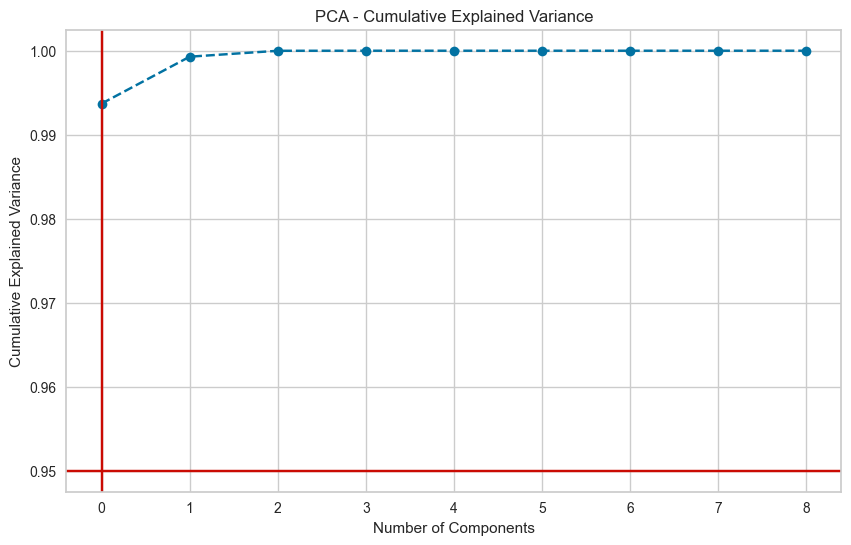

In [70]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
selected_columns = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1'
]
# 주어진 변수들로 PCA를 수행할 데이터 선택
X_train_pca_selected = X_train[selected_columns]


# PCA 수행 (모든 주성분 추출)
pca = PCA()
pca.fit(X_train_pca_selected)

# 설명된 분산 비율 계산
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# 누적 설명된 분산 비율 출력
print("Cumulative explained variance ratio:")
print(cumulative_variance_ratio)

# 몇 개의 주성분이 필요할지 결정
desired_variance_explained = 0.95  # 설명하고자 하는 분산 비율 설정 (예: 95%)
num_components = np.argmax(cumulative_variance_ratio >= desired_variance_explained) + 1
print(f"Number of components to explain {desired_variance_explained*100}% of the variance: {num_components}")

# 시각화 (선택 사항)
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.axhline(y=desired_variance_explained, color='r', linestyle='-')
plt.axvline(x=num_components - 1, color='r', linestyle='-')
plt.show()

In [ ]:
# NaN 값 처리 (평균으로 대체)
X_train_pca['PC1'].fillna(X_train_pca['PC1'].mean(), inplace=True)

In [72]:
value_counts = X_train_fill1_with_pc1['PC1'].value_counts(normalize=True, dropna=False) * 100

# 결과 출력
print(value_counts.to_string())

PC1
 NaN           19.886434
-587.841146     7.205901
 957.552042     6.351068
-587.841407     5.440686
-588.533885     5.166029
 957.205560     5.104308
-589.169194     3.851376
-587.841419     3.663128
-588.533891     3.545859
-588.187684     3.308234
-587.841174     3.286631
 957.551892     2.802123
-587.841187     2.626219
 957.552093     1.573880
 957.839837     1.499815
 957.551904     1.475127
 959.976157     1.459696
 957.494109     1.348599
-588.534166     1.246760
-587.840986     1.203555
 957.552043     1.181953
-588.533752     1.181953
-588.534445     1.169609
-587.840833     1.033823
 957.552246     1.006049
-587.841183     0.953586
 957.551608     0.913467
 957.551863     0.839403
 957.494120     0.817800
 957.552232     0.793112
 957.551603     0.638810
-587.841179     0.518455
-587.840853     0.509196
-588.476183     0.496852
-589.169190     0.459820
 960.899966     0.441304
 957.839844     0.425873
-587.840993     0.416615
 957.552099     0.391927
 957.840428     0.345

In [74]:
selected_features = ['Workorder_Dam_encoded', 'Production Qty Collect Result_Fill1', 
                     'PC1']  
X_train_pca = X_train_fill1_with_pc1[selected_features]
X_train_pca

,Workorder_Dam_encoded,Production Qty Collect Result_Fill1,PC1
24811,0.142857,330,957.552042
12549,0.058824,8,-588.533885
4956,0.007752,205,957.551603
1781,0.000000,130,957.552043
35415,0.088235,13,NaN
...,...,...,...
5856,0.025000,19,957.552043
12026,0.011494,152,-587.840986
13286,0.069231,192,-587.841419
1593,0.023810,28,-587.841174


In [75]:
# NaN 값 처리 (평균으로 대체)
X_train_pca['PC1'].fillna(X_train_pca['PC1'].mean(), inplace=True)

In [76]:
# 1. X_valid에 PCA 적용 후 'PC1' 추가
X_valid_fill1_with_pc1 = X_valid.copy()
X_valid_pca_selected = X_valid_fill1_with_pc1[selected_columns]

# 이미 학습된 PCA 모델로 변환 수행
pca_result_valid = pca.transform(X_valid_pca_selected)
X_valid_fill1_with_pc1['PC1'] = pca_result_valid[:, 0]

# 2. 필요한 변수를 선택
selected_features = ['Workorder_Dam_encoded', 'Production Qty Collect Result_Fill1', 
                     'PC1']  
X_valid_pca = X_valid_fill1_with_pc1[selected_features]

In [77]:
clf = setup(data = X_train_pca, target = y_train, session_id = RANDOM_STATE)
models = compare_models(sort = 'F1', n_select = 10)

kfold = 5  # kfold 값을 5로 변경

def my_tune_model(model_name, fold, n_iter, optimize):
  m = create_model(model_name, fold = kfold)
  return tune_model(m, fold = kfold, n_iter = n_iter, optimize = optimize)


model_list = []
#for model_name in ['catboost', 'rf', 'et', 'lightgbm', 'xgboost', 'gbc', 'ada', 'knn', 'lda']:
for model_name in ['catboost', 'rf', 'et', 'lightgbm', 'xgboost']:
  model_list.append(my_tune_model(model_name, fold = kfold, n_iter = 5, optimize = 'F1'))  # n_iter 값을 5로 변경

blended_model = blend_models(estimator_list = model_list,
                       fold = kfold,
                       method = 'soft',
                       optimize='F1'
                       )

from sklearn.metrics import f1_score
y_pred = predict_model(blended_model, data = X_valid_pca)
thresholds = np.arange(0.50, 1.00, 0.01)

f1_scores = []

for threshold in thresholds:
    # 임계값을 기준으로 라벨 생성
    y_valid_pred = ['Normal' if score >= threshold else 'AbNormal' for score in y_pred['prediction_score']]

    # F1 스코어 계산
    f1 = f1_score(y_valid, y_valid_pred, pos_label='AbNormal')
    f1_scores.append((threshold, f1))

# 결과 출력
for threshold, f1 in f1_scores:
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")

,Description,Value
0,Session id,110
1,Target,target
2,Target type,Binary
3,Target mapping,"AbNormal: 0, Normal: 1"
4,Original data shape,"(32404, 4)"
5,Transformed data shape,"(32404, 4)"
6,Transformed train set shape,"(22682, 4)"
7,Transformed test set shape,"(9722, 4)"
8,Numeric features,3
9,Rows with missing values,0.0%


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9421,0.6038,0.9421,0.9193,0.9175,0.0569,0.1198,0.0800
lda,Linear Discriminant Analysis,0.9400,0.6525,0.9400,0.9105,0.9174,0.0687,0.1112,0.0340
lightgbm,Light Gradient Boosting Machine,0.9426,0.6242,0.9426,0.9223,0.9174,0.0511,0.1208,0.2690
catboost,CatBoost Classifier,0.9421,0.6283,0.9421,0.9193,0.9171,0.0500,0.1132,4.0610
gbc,Gradient Boosting Classifier,0.9426,0.6510,0.9426,0.9306,0.9170,0.0452,0.1231,0.3050
lr,Logistic Regression,0.9426,0.6516,0.9426,0.9321,0.9160,0.0301,0.1024,0.6100
ridge,Ridge Classifier,0.9426,0.6525,0.9426,0.9320,0.9159,0.0287,0.0989,0.0350
rf,Random Forest Classifier,0.9375,0.5990,0.9375,0.9043,0.9158,0.0587,0.0851,0.3790
ada,Ada Boost Classifier,0.9422,0.6425,0.9422,0.9222,0.9156,0.0253,0.0811,0.1330
nb,Naive Bayes,0.9330,0.6177,0.9330,0.9041,0.9155,0.0851,0.1021,0.0310


Processing:   0%|          | 0/78 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9425,0.6035,0.9425,0.9246,0.9162,0.0336,0.1020
1,0.9429,0.6203,0.9429,0.9290,0.9179,0.0598,0.1452
2,0.9420,0.6544,0.9420,0.9173,0.9160,0.0325,0.0889
3,0.9409,0.6366,0.9409,0.9059,0.9150,0.0237,0.0573
4,0.9414,0.6310,0.9414,0.9139,0.9172,0.0553,0.1081
Mean,0.9419,0.6292,0.9419,0.9181,0.9165,0.0410,0.1003
Std,0.0007,0.0169,0.0007,0.0081,0.0010,0.0140,0.0285


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9427,0.6248,0.9427,0.9298,0.9164,0.0341,0.1104
1,0.9429,0.6212,0.9429,0.9290,0.9179,0.0598,0.1452
2,0.9422,0.6646,0.9422,0.9201,0.9165,0.0393,0.1028
3,0.9418,0.6421,0.9418,0.9157,0.9167,0.0444,0.1007
4,0.9422,0.6238,0.9422,0.9201,0.9165,0.0393,0.1028
Mean,0.9424,0.6353,0.9424,0.9230,0.9168,0.0434,0.1124
Std,0.0004,0.0164,0.0004,0.0055,0.0006,0.0088,0.0167


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9383,0.6061,0.9383,0.8989,0.9140,0.0239,0.0421
1,0.9389,0.6016,0.9389,0.9063,0.9160,0.0551,0.0895
2,0.9407,0.6478,0.9407,0.9159,0.9203,0.1090,0.1583
3,0.9361,0.6065,0.9361,0.9021,0.9149,0.0533,0.0745
4,0.9372,0.5985,0.9372,0.9028,0.9152,0.0504,0.0745
Mean,0.9382,0.6121,0.9382,0.9052,0.9161,0.0583,0.0878
Std,0.0016,0.0181,0.0016,0.0058,0.0022,0.0277,0.0385


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
1,0.9418,0.5000,0.9418,0.8870,0.9136,0.0000,0.0000
2,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
3,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
4,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
Mean,0.9420,0.5000,0.9420,0.8873,0.9138,0.0000,0.0000
Std,0.0001,0.0000,0.0001,0.0002,0.0001,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9317,0.5684,0.9317,0.8966,0.9118,0.0327,0.0415
1,0.9312,0.5855,0.9312,0.8976,0.9120,0.0425,0.0529
2,0.9299,0.6100,0.9299,0.9032,0.9144,0.0882,0.1003
3,0.9301,0.5839,0.9301,0.8979,0.9119,0.0451,0.0543
4,0.9290,0.5745,0.9290,0.9010,0.9130,0.0720,0.0823
Mean,0.9304,0.5845,0.9304,0.8993,0.9126,0.0561,0.0663
Std,0.0010,0.0142,0.0010,0.0025,0.0010,0.0207,0.0217


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
1,0.9418,0.5000,0.9418,0.8870,0.9136,0.0000,0.0000
2,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
3,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
4,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
Mean,0.9420,0.5000,0.9420,0.8873,0.9138,0.0000,0.0000
Std,0.0001,0.0000,0.0001,0.0002,0.0001,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9420,0.6040,0.9420,0.9170,0.9152,0.0198,0.0688
1,0.9425,0.6111,0.9425,0.9254,0.9168,0.0465,0.1218
2,0.9431,0.6569,0.9431,0.9293,0.9182,0.0601,0.1455
3,0.9420,0.6213,0.9420,0.9184,0.9183,0.0689,0.1320
4,0.9429,0.6258,0.9429,0.9264,0.9180,0.0595,0.1392
Mean,0.9425,0.6238,0.9425,0.9233,0.9173,0.0509,0.1215
Std,0.0004,0.0182,0.0004,0.0048,0.0012,0.0171,0.0275


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9423,0.6397,0.9423,0.9264,0.9149,0.0137,0.0670
1,0.9423,0.6371,0.9423,0.9266,0.9155,0.0271,0.0946
2,0.9431,0.6652,0.9431,0.9311,0.9178,0.0540,0.1412
3,0.9422,0.6428,0.9422,0.9201,0.9165,0.0393,0.1028
4,0.9420,0.6175,0.9420,0.9175,0.9164,0.0388,0.0974
Mean,0.9424,0.6404,0.9424,0.9243,0.9162,0.0346,0.1006
Std,0.0004,0.0152,0.0004,0.0049,0.0010,0.0135,0.0238


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9420,0.5944,0.9420,0.9173,0.9160,0.0325,0.0889
1,0.9429,0.6044,0.9429,0.9267,0.9186,0.0718,0.1543
2,0.9436,0.6284,0.9436,0.9287,0.9203,0.0908,0.1776
3,0.9418,0.5987,0.9418,0.9161,0.9170,0.0505,0.1083
4,0.9409,0.5804,0.9409,0.9109,0.9166,0.0482,0.0942
Mean,0.9422,0.6013,0.9422,0.9200,0.9177,0.0587,0.1247
Std,0.0009,0.0157,0.0009,0.0067,0.0016,0.0203,0.0351


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9400,0.5832,0.9400,0.8966,0.9137,0.0091,0.0220
1,0.9414,0.6083,0.9414,0.9137,0.9162,0.0436,0.0964
2,0.9385,0.6014,0.9385,0.9007,0.9145,0.0304,0.0527
3,0.9420,0.5427,0.9420,0.9177,0.9168,0.0449,0.1052
4,0.9418,0.5457,0.9418,0.9165,0.9174,0.0565,0.1154
Mean,0.9407,0.5762,0.9407,0.9091,0.9157,0.0369,0.0783
Std,0.0013,0.0274,0.0013,0.0087,0.0014,0.0162,0.0354


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9427,0.6213,0.9427,0.9460,0.9155,0.0213,0.1037
1,0.9427,0.6198,0.9427,0.9365,0.9162,0.0345,0.1205
2,0.9427,0.6639,0.9427,0.9298,0.9163,0.0341,0.1104
3,0.9429,0.6295,0.9429,0.9320,0.9169,0.0410,0.1245
4,0.9431,0.6141,0.9431,0.9338,0.9174,0.0478,0.1373
Mean,0.9428,0.6297,0.9428,0.9356,0.9165,0.0358,0.1193
Std,0.0002,0.0178,0.0002,0.0056,0.0006,0.0088,0.0116


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Threshold: 0.50, F1 Score: 0.0000
Threshold: 0.51, F1 Score: 0.0000
Threshold: 0.52, F1 Score: 0.0000
Threshold: 0.53, F1 Score: 0.0084
Threshold: 0.54, F1 Score: 0.0209
Threshold: 0.55, F1 Score: 0.0290
Threshold: 0.56, F1 Score: 0.0329
Threshold: 0.57, F1 Score: 0.0327
Threshold: 0.58, F1 Score: 0.0327
Threshold: 0.59, F1 Score: 0.0327
Threshold: 0.60, F1 Score: 0.0326
Threshold: 0.61, F1 Score: 0.0364
Threshold: 0.62, F1 Score: 0.0441
Threshold: 0.63, F1 Score: 0.0441
Threshold: 0.64, F1 Score: 0.0557
Threshold: 0.65, F1 Score: 0.0671
Threshold: 0.66, F1 Score: 0.0784
Threshold: 0.67, F1 Score: 0.0856
Threshold: 0.68, F1 Score: 0.0854
Threshold: 0.69, F1 Score: 0.0888
Threshold: 0.70, F1 Score: 0.0960
Threshold: 0.71, F1 Score: 0.0958
Threshold: 0.72, F1 Score: 0.1021
Threshold: 0.73, F1 Score: 0.1015
Threshold: 0.74, F1 Score: 0.1043
Threshold: 0.75, F1 Score: 0.1070
Threshold: 0.76, F1 Score: 0.1060
Threshold: 0.77, F1 Score: 0.1087
Threshold: 0.78, F1 Score: 0.1066
Threshold: 0.7

## fill2 공정 

## fill2 공정은 조합이 좀많음
- purge speed 변수와 head를 한방에 pca?
- 따로따로 pca?
- 한방에 한경우 모델 예측성능
- 따로따로 한경우 어떤 조합이 예측성능이?


### pca 없이


In [79]:
# Step 1: 특정 변수 선택
selected_features = ['Workorder_Dam_encoded', 'Production Qty Collect Result_Fill2', 
                     'CURE SPEED Collect Result_Fill2','Head Purge Position Z Collect Result_Fill2']  # 스케일링할 변수들
X_train_features = X_train[selected_features]
X_train_features

,Workorder_Dam_encoded,Production Qty Collect Result_Fill2,CURE SPEED Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2
24811,0.142857,330,50,85.000
12549,0.058824,8,50,85.000
4956,0.007752,205,50,85.000
1781,0.000000,130,48,114.612
35415,0.088235,13,45,114.612
...,...,...,...,...
5856,0.025000,19,50,85.000
12026,0.011494,152,50,114.612
13286,0.069231,192,50,85.000
1593,0.023810,28,50,85.000


In [80]:
clf = setup(data = X_train_features, target = y_train, session_id = RANDOM_STATE)
models = compare_models(sort = 'F1', n_select = 10)

kfold = 5  # kfold 값을 5로 변경

def my_tune_model(model_name, fold, n_iter, optimize):
  m = create_model(model_name, fold = kfold)
  return tune_model(m, fold = kfold, n_iter = n_iter, optimize = optimize)


model_list = []
#for model_name in ['catboost', 'rf', 'et', 'lightgbm', 'xgboost', 'gbc', 'ada', 'knn', 'lda']:
for model_name in ['catboost', 'rf', 'et', 'lightgbm', 'xgboost']:
  model_list.append(my_tune_model(model_name, fold = kfold, n_iter = 5, optimize = 'F1'))  # n_iter 값을 5로 변경

blended_model = blend_models(estimator_list = model_list,
                       fold = kfold,
                       method = 'soft',
                       optimize='F1'
                       )

from sklearn.metrics import f1_score
y_pred = predict_model(blended_model, data = X_valid)
thresholds = np.arange(0.50, 1.00, 0.01)

f1_scores = []

for threshold in thresholds:
    # 임계값을 기준으로 라벨 생성
    y_valid_pred = ['Normal' if score >= threshold else 'AbNormal' for score in y_pred['prediction_score']]

    # F1 스코어 계산
    f1 = f1_score(y_valid, y_valid_pred, pos_label='AbNormal')
    f1_scores.append((threshold, f1))

# 결과 출력
for threshold, f1 in f1_scores:
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")

,Description,Value
0,Session id,110
1,Target,target
2,Target type,Binary
3,Target mapping,"AbNormal: 0, Normal: 1"
4,Original data shape,"(32404, 5)"
5,Transformed data shape,"(32404, 5)"
6,Transformed train set shape,"(22682, 5)"
7,Transformed test set shape,"(9722, 5)"
8,Numeric features,4
9,Rows with missing values,0.0%


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9421,0.6257,0.9421,0.9202,0.9178,0.0607,0.1264,0.0790
lda,Linear Discriminant Analysis,0.9400,0.6532,0.9400,0.9107,0.9175,0.0690,0.1122,0.0320
catboost,CatBoost Classifier,0.9422,0.6497,0.9422,0.9190,0.9175,0.0562,0.1195,4.0260
lightgbm,Light Gradient Boosting Machine,0.9425,0.6493,0.9425,0.9229,0.9174,0.0530,0.1219,0.2630
gbc,Gradient Boosting Classifier,0.9421,0.6517,0.9421,0.9225,0.9164,0.0388,0.1014,0.2720
lr,Logistic Regression,0.9426,0.6536,0.9426,0.9321,0.9160,0.0301,0.1024,0.6000
ridge,Ridge Classifier,0.9426,0.6532,0.9426,0.9320,0.9159,0.0287,0.0989,0.0340
ada,Ada Boost Classifier,0.9422,0.6435,0.9422,0.9222,0.9156,0.0253,0.0811,0.1310
nb,Naive Bayes,0.9306,0.6163,0.9306,0.9045,0.9152,0.0971,0.1106,0.0320
qda,Quadratic Discriminant Analysis,0.9296,0.6095,0.9296,0.9039,0.9146,0.0952,0.1070,0.0310


Processing:   0%|          | 0/78 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9425,0.6494,0.9425,0.9233,0.9166,0.0399,0.1090
1,0.9427,0.6255,0.9427,0.9246,0.9185,0.0711,0.1491
2,0.9418,0.6655,0.9418,0.9161,0.9170,0.0505,0.1083
3,0.9427,0.6705,0.9427,0.9234,0.9183,0.0648,0.1392
4,0.9427,0.6306,0.9427,0.9234,0.9183,0.0648,0.1392
Mean,0.9425,0.6483,0.9425,0.9222,0.9178,0.0582,0.1289
Std,0.0003,0.0180,0.0003,0.0031,0.0008,0.0114,0.0170


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9427,0.6471,0.9427,0.9272,0.9168,0.0404,0.1161
1,0.9427,0.6357,0.9427,0.9246,0.9185,0.0711,0.1491
2,0.9420,0.6688,0.9420,0.9177,0.9168,0.0449,0.1052
3,0.9431,0.6679,0.9431,0.9280,0.9186,0.0661,0.1500
4,0.9429,0.6430,0.9429,0.9264,0.9180,0.0595,0.1392
Mean,0.9427,0.6525,0.9427,0.9248,0.9177,0.0564,0.1319
Std,0.0004,0.0134,0.0004,0.0037,0.0008,0.0119,0.0181


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9339,0.6103,0.9339,0.9021,0.9147,0.0639,0.0812
1,0.9297,0.5975,0.9297,0.9012,0.9133,0.0738,0.0853
2,0.9290,0.6282,0.9290,0.9032,0.9141,0.0905,0.1015
3,0.9292,0.6002,0.9292,0.8994,0.9123,0.0581,0.0677
4,0.9323,0.6130,0.9323,0.9027,0.9147,0.0752,0.0905
Mean,0.9308,0.6098,0.9308,0.9017,0.9138,0.0723,0.0853
Std,0.0019,0.0109,0.0019,0.0013,0.0009,0.0111,0.0111


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
1,0.9418,0.5000,0.9418,0.8870,0.9136,0.0000,0.0000
2,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
3,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
4,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
Mean,0.9420,0.5000,0.9420,0.8873,0.9138,0.0000,0.0000
Std,0.0001,0.0000,0.0001,0.0002,0.0001,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9273,0.6106,0.9273,0.9032,0.9136,0.0951,0.1040
1,0.9193,0.5752,0.9193,0.9000,0.9090,0.0811,0.0845
2,0.9169,0.6034,0.9169,0.9013,0.9086,0.0917,0.0940
3,0.9209,0.5955,0.9209,0.9013,0.9103,0.0885,0.0925
4,0.9211,0.5740,0.9211,0.8981,0.9087,0.0593,0.0631
Mean,0.9211,0.5918,0.9211,0.9008,0.9101,0.0831,0.0876
Std,0.0034,0.0148,0.0034,0.0017,0.0019,0.0128,0.0137


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
1,0.9418,0.5000,0.9418,0.8870,0.9136,0.0000,0.0000
2,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
3,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
4,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
Mean,0.9420,0.5000,0.9420,0.8873,0.9138,0.0000,0.0000
Std,0.0001,0.0000,0.0001,0.0002,0.0001,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9425,0.6348,0.9425,0.9268,0.9158,0.0272,0.0948
1,0.9431,0.6249,0.9431,0.9291,0.9188,0.0724,0.1599
2,0.9431,0.6710,0.9431,0.9280,0.9186,0.0661,0.1500
3,0.9427,0.6514,0.9427,0.9239,0.9179,0.0589,0.1336
4,0.9427,0.6332,0.9427,0.9246,0.9175,0.0528,0.1279
Mean,0.9428,0.6431,0.9428,0.9265,0.9177,0.0555,0.1332
Std,0.0003,0.0164,0.0003,0.0020,0.0010,0.0156,0.0224


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9423,0.6502,0.9423,0.9456,0.9145,0.0071,0.0599
1,0.9423,0.6350,0.9423,0.9266,0.9155,0.0271,0.0946
2,0.9431,0.6704,0.9431,0.9464,0.9166,0.0352,0.1339
3,0.9429,0.6486,0.9429,0.9320,0.9169,0.0410,0.1245
4,0.9429,0.6400,0.9429,0.9462,0.9160,0.0283,0.1197
Mean,0.9427,0.6488,0.9427,0.9393,0.9159,0.0278,0.1065
Std,0.0004,0.0121,0.0004,0.0084,0.0009,0.0115,0.0267


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9418,0.6214,0.9418,0.9153,0.9163,0.0382,0.0926
1,0.9431,0.5999,0.9431,0.9281,0.9191,0.0783,0.1640
2,0.9427,0.6477,0.9427,0.9228,0.9190,0.0766,0.1498
3,0.9403,0.6155,0.9403,0.9113,0.9177,0.0697,0.1143
4,0.9414,0.6114,0.9414,0.9144,0.9176,0.0612,0.1151
Mean,0.9418,0.6192,0.9418,0.9184,0.9179,0.0648,0.1272
Std,0.0010,0.0159,0.0010,0.0062,0.0011,0.0146,0.0260


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9423,0.5630,0.9423,0.9213,0.9157,0.0267,0.0864
1,0.9414,0.5789,0.9414,0.9110,0.9150,0.0251,0.0686
2,0.9414,0.6009,0.9414,0.9117,0.9160,0.0371,0.0843
3,0.9414,0.5676,0.9414,0.9092,0.9152,0.0247,0.0645
4,0.9418,0.5635,0.9418,0.9147,0.9159,0.0320,0.0837
Mean,0.9416,0.5748,0.9416,0.9136,0.9156,0.0291,0.0775
Std,0.0004,0.0143,0.0004,0.0043,0.0004,0.0048,0.0091


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9427,0.6397,0.9427,0.9460,0.9155,0.0213,0.1037
1,0.9431,0.6208,0.9431,0.9324,0.9180,0.0605,0.1522
2,0.9431,0.6645,0.9431,0.9311,0.9178,0.0540,0.1412
3,0.9429,0.6479,0.9429,0.9293,0.9173,0.0472,0.1291
4,0.9431,0.6325,0.9431,0.9293,0.9182,0.0601,0.1455
Mean,0.9430,0.6411,0.9430,0.9336,0.9173,0.0486,0.1343
Std,0.0002,0.0147,0.0002,0.0063,0.0010,0.0145,0.0171


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Threshold: 0.50, F1 Score: 0.0000
Threshold: 0.51, F1 Score: 0.0042
Threshold: 0.52, F1 Score: 0.0168
Threshold: 0.53, F1 Score: 0.0167
Threshold: 0.54, F1 Score: 0.0289
Threshold: 0.55, F1 Score: 0.0329
Threshold: 0.56, F1 Score: 0.0407
Threshold: 0.57, F1 Score: 0.0405
Threshold: 0.58, F1 Score: 0.0522
Threshold: 0.59, F1 Score: 0.0522
Threshold: 0.60, F1 Score: 0.0559
Threshold: 0.61, F1 Score: 0.0559
Threshold: 0.62, F1 Score: 0.0598
Threshold: 0.63, F1 Score: 0.0596
Threshold: 0.64, F1 Score: 0.0668
Threshold: 0.65, F1 Score: 0.0706
Threshold: 0.66, F1 Score: 0.0781
Threshold: 0.67, F1 Score: 0.0817
Threshold: 0.68, F1 Score: 0.0851
Threshold: 0.69, F1 Score: 0.0921
Threshold: 0.70, F1 Score: 0.0992
Threshold: 0.71, F1 Score: 0.1025
Threshold: 0.72, F1 Score: 0.1080
Threshold: 0.73, F1 Score: 0.1133
Threshold: 0.74, F1 Score: 0.1198
Threshold: 0.75, F1 Score: 0.1241
Threshold: 0.76, F1 Score: 0.1352
Threshold: 0.77, F1 Score: 0.1363
Threshold: 0.78, F1 Score: 0.1388
Threshold: 0.7

In [ ]:
Head Purge Position X Collect Result_Fill2

### purge에 pca하면 성능 거의 차이없음

In [82]:
from sklearn.decomposition import PCA
import pandas as pd

# 예를 들어, 'df'라는 데이터프레임에 모든 데이터가 있다고 가정합니다.
# 주어진 변수들만 선택합니다.
selected_columns = [
    'Head Purge Position X Collect Result_Fill2',
    'Head Purge Position Y Collect Result_Fill2',
    'Head Purge Position Z Collect Result_Fill2'
   ]


# 선택한 변수들로 데이터프레임 구성
X_train_pca_selected_fill2 = X_train[selected_columns]

# PCA 수행
pca = PCA(n_components=1)  # 첫 번째 주성분만 추출
pca_result = pca.fit_transform(X_train_pca_selected_fill2)

# PCA 결과를 데이터프레임으로 변환
pca_df = pd.DataFrame(pca_result, columns=['PC1'])

# 기존 X_train을 복사하여 새로운 데이터프레임 생성
X_train_fill2_with_pc1 = X_train.copy()

# 복사된 데이터프레임에 PC1 열 추가
X_train_fill2_with_pc1['PC1'] = pca_df['PC1']

# PCA 결과가 추가된 데이터프레임 출력
print(X_train_fill2_with_pc1.head())

      Wip Line_Dam Process Desc._Dam     Equipment_Dam Model.Suffix_Dam  \
24811      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
12549      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
4956       IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
1781       IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
35415      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   

      Workorder_Dam  Insp. Seq No._Dam Insp Judge Code_Dam  \
24811    3G1XA501-1                  1                  OK   
12549    3G1XD204-1                  1                  OK   
4956     3L1XA128-1                  1                  OK   
1781     4E1XB382-1                  1                  OK   
35415    4E1XA548-1                  1                  OK   

       CURE END POSITION X Collect Result_Dam  \
24811                                   240.0   
12549                                   240.0   
4956                         

In [83]:
selected_features = ['Workorder_Dam_encoded', 'Production Qty Collect Result_Fill2', 
                     'CURE SPEED Collect Result_Fill2','PC1']  
X_train_pca = X_train_fill2_with_pc1[selected_features]
X_train_pca

,Workorder_Dam_encoded,Production Qty Collect Result_Fill2,CURE SPEED Collect Result_Fill2,PC1
24811,0.142857,330,50,-3.669059
12549,0.058824,8,50,-3.669059
4956,0.007752,205,50,-3.669059
1781,0.000000,130,48,-3.669059
35415,0.088235,13,45,NaN
...,...,...,...,...
5856,0.025000,19,50,-3.669059
12026,0.011494,152,50,-3.669059
13286,0.069231,192,50,-3.669059
1593,0.023810,28,50,-3.669059


In [84]:
# NaN 값 처리 (평균으로 대체)
X_train_pca['PC1'].fillna(X_train_pca['PC1'].mean(), inplace=True)

In [85]:
# 1. X_valid에 PCA 적용 후 'PC1' 추가
X_valid_fill2_with_pc1 = X_valid.copy()
X_valid_pca_selected = X_valid_fill2_with_pc1[selected_columns]

# 이미 학습된 PCA 모델로 변환 수행
pca_result_valid = pca.transform(X_valid_pca_selected)
X_valid_fill2_with_pc1['PC1'] = pca_result_valid[:, 0]

# 2. 필요한 변수를 선택
selected_features = ['Workorder_Dam_encoded', 'Production Qty Collect Result_Fill2','CURE SPEED Collect Result_Fill2', 
                     'PC1']  
X_valid_pca = X_valid_fill2_with_pc1[selected_features]

In [86]:
clf = setup(data = X_train_pca, target = y_train, session_id = RANDOM_STATE)
models = compare_models(sort = 'F1', n_select = 10)

kfold = 5  # kfold 값을 5로 변경

def my_tune_model(model_name, fold, n_iter, optimize):
  m = create_model(model_name, fold = kfold)
  return tune_model(m, fold = kfold, n_iter = n_iter, optimize = optimize)


model_list = []
#for model_name in ['catboost', 'rf', 'et', 'lightgbm', 'xgboost', 'gbc', 'ada', 'knn', 'lda']:
for model_name in ['catboost', 'rf', 'et', 'lightgbm', 'xgboost']:
  model_list.append(my_tune_model(model_name, fold = kfold, n_iter = 5, optimize = 'F1'))  # n_iter 값을 5로 변경

blended_model = blend_models(estimator_list = model_list,
                       fold = kfold,
                       method = 'soft',
                       optimize='F1'
                       )

from sklearn.metrics import f1_score
y_pred = predict_model(blended_model, data = X_valid_pca)
thresholds = np.arange(0.50, 1.00, 0.01)

f1_scores = []

for threshold in thresholds:
    # 임계값을 기준으로 라벨 생성
    y_valid_pred = ['Normal' if score >= threshold else 'AbNormal' for score in y_pred['prediction_score']]

    # F1 스코어 계산
    f1 = f1_score(y_valid, y_valid_pred, pos_label='AbNormal')
    f1_scores.append((threshold, f1))

# 결과 출력
for threshold, f1 in f1_scores:
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")

,Description,Value
0,Session id,110
1,Target,target
2,Target type,Binary
3,Target mapping,"AbNormal: 0, Normal: 1"
4,Original data shape,"(32404, 5)"
5,Transformed data shape,"(32404, 5)"
6,Transformed train set shape,"(22682, 5)"
7,Transformed test set shape,"(9722, 5)"
8,Numeric features,4
9,Rows with missing values,0.0%


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9422,0.6191,0.9422,0.9199,0.9181,0.0654,0.1305,0.0700
catboost,CatBoost Classifier,0.9422,0.6386,0.9422,0.9177,0.9177,0.0596,0.1208,3.7010
lightgbm,Light Gradient Boosting Machine,0.9426,0.6365,0.9426,0.9271,0.9175,0.0536,0.1306,0.2400
lda,Linear Discriminant Analysis,0.9400,0.6533,0.9400,0.9105,0.9174,0.0677,0.1104,0.0260
gbc,Gradient Boosting Classifier,0.9420,0.6477,0.9420,0.9156,0.9163,0.0385,0.0931,0.2510
lr,Logistic Regression,0.9426,0.6511,0.9426,0.9321,0.9160,0.0301,0.1024,0.5190
ridge,Ridge Classifier,0.9426,0.6533,0.9426,0.9320,0.9159,0.0287,0.0989,0.0300
ada,Ada Boost Classifier,0.9422,0.6440,0.9422,0.9222,0.9156,0.0253,0.0811,0.1150
svm,SVM - Linear Kernel,0.9417,0.5334,0.9417,0.9040,0.9152,0.0225,0.0488,0.0550
nb,Naive Bayes,0.9303,0.6141,0.9303,0.9042,0.9150,0.0953,0.1083,0.0260


Processing:   0%|          | 0/78 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9429,0.6263,0.9429,0.9293,0.9173,0.0472,0.1291
1,0.9420,0.6155,0.9420,0.9195,0.9181,0.0692,0.1356
2,0.9414,0.6633,0.9414,0.9125,0.9164,0.0433,0.0928
3,0.9429,0.6490,0.9429,0.9255,0.9184,0.0655,0.1444
4,0.9429,0.6231,0.9429,0.9249,0.9188,0.0714,0.1494
Mean,0.9424,0.6354,0.9424,0.9224,0.9178,0.0593,0.1303
Std,0.0006,0.0179,0.0006,0.0058,0.0009,0.0117,0.0200


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9425,0.6381,0.9425,0.9246,0.9162,0.0336,0.1020
1,0.9427,0.6214,0.9427,0.9246,0.9185,0.0711,0.1491
2,0.9420,0.6722,0.9420,0.9175,0.9164,0.0388,0.0974
3,0.9433,0.6584,0.9433,0.9294,0.9191,0.0727,0.1603
4,0.9429,0.6385,0.9429,0.9264,0.9180,0.0595,0.1392
Mean,0.9427,0.6457,0.9427,0.9245,0.9176,0.0551,0.1296
Std,0.0004,0.0177,0.0004,0.0039,0.0011,0.0162,0.0253


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9326,0.6074,0.9326,0.8962,0.9120,0.0291,0.0381
1,0.9321,0.5926,0.9321,0.9011,0.9138,0.0649,0.0795
2,0.9339,0.6132,0.9339,0.9046,0.9159,0.0841,0.1032
3,0.9308,0.5913,0.9308,0.9009,0.9135,0.0665,0.0787
4,0.9347,0.5941,0.9347,0.9055,0.9164,0.0864,0.1079
Mean,0.9328,0.5997,0.9328,0.9017,0.9143,0.0662,0.0815
Std,0.0014,0.0089,0.0014,0.0033,0.0016,0.0205,0.0247


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
1,0.9418,0.5000,0.9418,0.8870,0.9136,0.0000,0.0000
2,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
3,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
4,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
Mean,0.9420,0.5000,0.9420,0.8873,0.9138,0.0000,0.0000
Std,0.0001,0.0000,0.0001,0.0002,0.0001,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9242,0.5886,0.9242,0.8982,0.9100,0.0567,0.0620
1,0.9209,0.5689,0.9209,0.8982,0.9087,0.0634,0.0673
2,0.9198,0.6041,0.9198,0.9005,0.9094,0.0819,0.0854
3,0.9233,0.5794,0.9233,0.9004,0.9108,0.0770,0.0824
4,0.9239,0.5843,0.9239,0.9016,0.9117,0.0871,0.0931
Mean,0.9224,0.5851,0.9224,0.8998,0.9101,0.0732,0.0780
Std,0.0018,0.0116,0.0018,0.0014,0.0010,0.0114,0.0116


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
1,0.9418,0.5000,0.9418,0.8870,0.9136,0.0000,0.0000
2,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
3,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
4,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
Mean,0.9420,0.5000,0.9420,0.8873,0.9138,0.0000,0.0000
Std,0.0001,0.0000,0.0001,0.0002,0.0001,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9434,0.6313,0.9434,0.9353,0.9179,0.0546,0.1492
1,0.9423,0.6110,0.9423,0.9230,0.9163,0.0397,0.1088
2,0.9438,0.6676,0.9438,0.9318,0.9201,0.0857,0.1794
3,0.9416,0.6440,0.9416,0.9151,0.9173,0.0559,0.1116
4,0.9427,0.6273,0.9427,0.9239,0.9179,0.0589,0.1336
Mean,0.9427,0.6362,0.9427,0.9258,0.9179,0.0590,0.1365
Std,0.0008,0.0189,0.0008,0.0071,0.0012,0.0149,0.0261


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9423,0.6488,0.9423,0.9456,0.9145,0.0071,0.0599
1,0.9423,0.6358,0.9423,0.9266,0.9155,0.0271,0.0946
2,0.9431,0.6704,0.9431,0.9464,0.9166,0.0352,0.1339
3,0.9429,0.6485,0.9429,0.9320,0.9169,0.0410,0.1245
4,0.9429,0.6400,0.9429,0.9462,0.9160,0.0283,0.1197
Mean,0.9427,0.6487,0.9427,0.9393,0.9159,0.0278,0.1065
Std,0.0004,0.0119,0.0004,0.0084,0.0009,0.0115,0.0267


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9418,0.6117,0.9418,0.9158,0.9167,0.0444,0.1007
1,0.9427,0.5938,0.9427,0.9236,0.9196,0.0884,0.1636
2,0.9414,0.6511,0.9414,0.9153,0.9183,0.0727,0.1280
3,0.9400,0.6144,0.9400,0.9099,0.9172,0.0634,0.1054
4,0.9416,0.6307,0.9416,0.9156,0.9177,0.0618,0.1185
Mean,0.9415,0.6203,0.9415,0.9160,0.9179,0.0661,0.1232
Std,0.0009,0.0193,0.0009,0.0044,0.0010,0.0144,0.0224


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9414,0.5851,0.9414,0.9043,0.9144,0.0118,0.0383
1,0.9398,0.5411,0.9398,0.9013,0.9142,0.0216,0.0464
2,0.9418,0.5957,0.9418,0.9157,0.9167,0.0444,0.1007
3,0.9407,0.5661,0.9407,0.9024,0.9145,0.0168,0.0423
4,0.9414,0.5717,0.9414,0.9125,0.9164,0.0433,0.0928
Mean,0.9410,0.5719,0.9410,0.9073,0.9152,0.0276,0.0641
Std,0.0007,0.0186,0.0007,0.0058,0.0011,0.0136,0.0269


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9425,0.6330,0.9425,0.9315,0.9154,0.0208,0.0880
1,0.9431,0.6040,0.9431,0.9351,0.9176,0.0544,0.1489
2,0.9436,0.6605,0.9436,0.9339,0.9188,0.0674,0.1632
3,0.9422,0.6391,0.9422,0.9201,0.9165,0.0393,0.1028
4,0.9433,0.6321,0.9433,0.9326,0.9183,0.0607,0.1525
Mean,0.9430,0.6337,0.9430,0.9307,0.9173,0.0485,0.1311
Std,0.0005,0.0181,0.0005,0.0054,0.0012,0.0167,0.0299


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Threshold: 0.50, F1 Score: 0.0000
Threshold: 0.51, F1 Score: 0.0127
Threshold: 0.52, F1 Score: 0.0209
Threshold: 0.53, F1 Score: 0.0290
Threshold: 0.54, F1 Score: 0.0330
Threshold: 0.55, F1 Score: 0.0328
Threshold: 0.56, F1 Score: 0.0367
Threshold: 0.57, F1 Score: 0.0524
Threshold: 0.58, F1 Score: 0.0563
Threshold: 0.59, F1 Score: 0.0561
Threshold: 0.60, F1 Score: 0.0600
Threshold: 0.61, F1 Score: 0.0675
Threshold: 0.62, F1 Score: 0.0784
Threshold: 0.63, F1 Score: 0.0822
Threshold: 0.64, F1 Score: 0.0856
Threshold: 0.65, F1 Score: 0.0854
Threshold: 0.66, F1 Score: 0.0851
Threshold: 0.67, F1 Score: 0.0848
Threshold: 0.68, F1 Score: 0.0883
Threshold: 0.69, F1 Score: 0.0914
Threshold: 0.70, F1 Score: 0.0913
Threshold: 0.71, F1 Score: 0.0985
Threshold: 0.72, F1 Score: 0.1047
Threshold: 0.73, F1 Score: 0.1076
Threshold: 0.74, F1 Score: 0.1062
Threshold: 0.75, F1 Score: 0.1290
Threshold: 0.76, F1 Score: 0.1391
Threshold: 0.77, F1 Score: 0.1399
Threshold: 0.78, F1 Score: 0.1513
Threshold: 0.7

### fill2 head 좌표 pca

In [87]:
from sklearn.decomposition import PCA
import pandas as pd


# 예를 들어, 'df'라는 데이터프레임에 모든 데이터가 있다고 가정합니다.
# 주어진 변수들만 선택합니다.
selected_columns = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2',
    'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2',
   ]


# 선택한 변수들로 데이터프레임 구성
X_train_pca_selected_fill2_head = X_train[selected_columns]

# PCA 수행
pca = PCA(n_components=1)  # 첫 번째 주성분만 추출
pca_result = pca.fit_transform(X_train_pca_selected_fill2_head)

# PCA 결과를 데이터프레임으로 변환
pca_df = pd.DataFrame(pca_result, columns=['PC1'])

# 기존 X_train을 복사하여 새로운 데이터프레임 생성
X_train_fill2_with_pc1_head = X_train.copy()

# 복사된 데이터프레임에 PC1 열 추가
X_train_fill2_with_pc1_head['PC1'] = pca_df['PC1']

# PCA 결과가 추가된 데이터프레임 출력
print(X_train_fill2_with_pc1_head.head())
    




      Wip Line_Dam Process Desc._Dam     Equipment_Dam Model.Suffix_Dam  \
24811      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
12549      IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
4956       IVI-OB6     Dam Dispenser  Dam dispenser #1      AJX75334501   
1781       IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334505   
35415      IVI-OB6     Dam Dispenser  Dam dispenser #2      AJX75334501   

      Workorder_Dam  Insp. Seq No._Dam Insp Judge Code_Dam  \
24811    3G1XA501-1                  1                  OK   
12549    3G1XD204-1                  1                  OK   
4956     3L1XA128-1                  1                  OK   
1781     4E1XB382-1                  1                  OK   
35415    4E1XA548-1                  1                  OK   

       CURE END POSITION X Collect Result_Dam  \
24811                                   240.0   
12549                                   240.0   
4956                         

In [88]:
selected_features = ['Workorder_Dam_encoded', 'Production Qty Collect Result_Fill2', 
                     'PC1']  
X_train_pca = X_train_fill2_with_pc1_head[selected_features]
X_train_pca

,Workorder_Dam_encoded,Production Qty Collect Result_Fill2,PC1
24811,0.142857,330,1069.885085
12549,0.058824,8,-657.055613
4956,0.007752,205,1069.885085
1781,0.000000,130,1069.885085
35415,0.088235,13,NaN
...,...,...,...
5856,0.025000,19,1069.885085
12026,0.011494,152,-657.055613
13286,0.069231,192,-657.055613
1593,0.023810,28,-657.055613


In [89]:
# NaN 값 처리 (평균으로 대체)
X_train_pca['PC1'].fillna(X_train_pca['PC1'].mean(), inplace=True)

In [90]:
# 1. X_valid에 PCA 적용 후 'PC1' 추가
X_valid_fill2_with_pc1_head = X_valid.copy()
X_valid_pca_selected = X_valid_fill2_with_pc1_head[selected_columns]

# 이미 학습된 PCA 모델로 변환 수행
pca_result_valid = pca.transform(X_valid_pca_selected)
X_valid_fill2_with_pc1_head['PC1'] = pca_result_valid[:, 0]

# 2. 필요한 변수를 선택
selected_features = ['Workorder_Dam_encoded', 'Production Qty Collect Result_Fill2', 
                     'PC1']  
X_valid_pca = X_valid_fill2_with_pc1_head[selected_features]

In [91]:
clf = setup(data = X_train_pca, target = y_train, session_id = RANDOM_STATE)
models = compare_models(sort = 'F1', n_select = 10)

kfold = 5  # kfold 값을 5로 변경

def my_tune_model(model_name, fold, n_iter, optimize):
  m = create_model(model_name, fold = kfold)
  return tune_model(m, fold = kfold, n_iter = n_iter, optimize = optimize)


model_list = []
#for model_name in ['catboost', 'rf', 'et', 'lightgbm', 'xgboost', 'gbc', 'ada', 'knn', 'lda']:
for model_name in ['catboost', 'rf', 'et', 'lightgbm', 'xgboost']:
  model_list.append(my_tune_model(model_name, fold = kfold, n_iter = 5, optimize = 'F1'))  # n_iter 값을 5로 변경

blended_model = blend_models(estimator_list = model_list,
                       fold = kfold,
                       method = 'soft',
                       optimize='F1'
                       )

from sklearn.metrics import f1_score
y_pred = predict_model(blended_model, data = X_valid_pca)
thresholds = np.arange(0.50, 1.00, 0.01)

f1_scores = []

for threshold in thresholds:
    # 임계값을 기준으로 라벨 생성
    y_valid_pred = ['Normal' if score >= threshold else 'AbNormal' for score in y_pred['prediction_score']]

    # F1 스코어 계산
    f1 = f1_score(y_valid, y_valid_pred, pos_label='AbNormal')
    f1_scores.append((threshold, f1))

# 결과 출력
for threshold, f1 in f1_scores:
    print(f"Threshold: {threshold:.2f}, F1 Score: {f1:.4f}")

,Description,Value
0,Session id,110
1,Target,target
2,Target type,Binary
3,Target mapping,"AbNormal: 0, Normal: 1"
4,Original data shape,"(32404, 4)"
5,Transformed data shape,"(32404, 4)"
6,Transformed train set shape,"(22682, 4)"
7,Transformed test set shape,"(9722, 4)"
8,Numeric features,3
9,Rows with missing values,0.0%


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.9399,0.6525,0.9399,0.9104,0.9174,0.0686,0.1108,0.0260
xgboost,Extreme Gradient Boosting,0.9419,0.6153,0.9419,0.9162,0.9173,0.0553,0.1128,0.0670
lightgbm,Light Gradient Boosting Machine,0.9424,0.6332,0.9424,0.9224,0.9172,0.0493,0.1170,0.2340
catboost,CatBoost Classifier,0.9420,0.6367,0.9420,0.9166,0.9171,0.0509,0.1093,3.6410
gbc,Gradient Boosting Classifier,0.9424,0.6486,0.9424,0.9243,0.9169,0.0445,0.1123,0.2490
lr,Logistic Regression,0.9426,0.6513,0.9426,0.9321,0.9160,0.0301,0.1024,0.5080
ridge,Ridge Classifier,0.9426,0.6525,0.9426,0.9320,0.9159,0.0287,0.0989,0.0250
nb,Naive Bayes,0.9338,0.6179,0.9338,0.9045,0.9158,0.0844,0.1031,0.0240
ada,Ada Boost Classifier,0.9422,0.6456,0.9422,0.9222,0.9156,0.0253,0.0811,0.1170
qda,Quadratic Discriminant Analysis,0.9309,0.6120,0.9309,0.9045,0.9153,0.0960,0.1100,0.0250


Processing:   0%|          | 0/78 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9423,0.6248,0.9423,0.9202,0.9165,0.0393,0.1028
1,0.9427,0.6179,0.9427,0.9253,0.9181,0.0652,0.1440
2,0.9429,0.6563,0.9429,0.9276,0.9177,0.0534,0.1341
3,0.9418,0.6509,0.9418,0.9165,0.9174,0.0565,0.1154
4,0.9422,0.6275,0.9422,0.9198,0.9181,0.0636,0.1300
Mean,0.9424,0.6355,0.9424,0.9219,0.9176,0.0556,0.1253
Std,0.0004,0.0152,0.0004,0.0040,0.0006,0.0092,0.0145


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9425,0.6213,0.9425,0.9233,0.9166,0.0399,0.1090
1,0.9429,0.6276,0.9429,0.9290,0.9179,0.0598,0.1452
2,0.9427,0.6507,0.9427,0.9272,0.9167,0.0404,0.1161
3,0.9418,0.6479,0.9418,0.9157,0.9167,0.0444,0.1007
4,0.9425,0.6416,0.9425,0.9217,0.9178,0.0583,0.1284
Mean,0.9425,0.6378,0.9425,0.9234,0.9171,0.0486,0.1199
Std,0.0004,0.0115,0.0004,0.0046,0.0006,0.0087,0.0156


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9356,0.5852,0.9356,0.9016,0.9147,0.0522,0.0720
1,0.9297,0.5773,0.9297,0.8974,0.9115,0.0444,0.0533
2,0.9345,0.6175,0.9345,0.9064,0.9169,0.0957,0.1170
3,0.9301,0.5982,0.9301,0.8993,0.9125,0.0551,0.0655
4,0.9334,0.5978,0.9334,0.9036,0.9153,0.0780,0.0957
Mean,0.9327,0.5952,0.9327,0.9017,0.9142,0.0651,0.0807
Std,0.0024,0.0137,0.0024,0.0032,0.0019,0.0190,0.0228


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
1,0.9418,0.5000,0.9418,0.8870,0.9136,0.0000,0.0000
2,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
3,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
4,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
Mean,0.9420,0.5000,0.9420,0.8873,0.9138,0.0000,0.0000
Std,0.0001,0.0000,0.0001,0.0002,0.0001,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9270,0.5574,0.9270,0.8970,0.9105,0.0436,0.0500
1,0.9209,0.5651,0.9209,0.8962,0.9076,0.0458,0.0491
2,0.9209,0.5992,0.9209,0.8985,0.9088,0.0632,0.0670
3,0.9209,0.5964,0.9209,0.8959,0.9075,0.0411,0.0442
4,0.9259,0.5942,0.9259,0.9015,0.9123,0.0831,0.0905
Mean,0.9231,0.5825,0.9231,0.8978,0.9094,0.0554,0.0602
Std,0.0028,0.0176,0.0028,0.0021,0.0018,0.0159,0.0170


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
1,0.9418,0.5000,0.9418,0.8870,0.9136,0.0000,0.0000
2,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
3,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
4,0.9420,0.5000,0.9420,0.8874,0.9139,0.0000,0.0000
Mean,0.9420,0.5000,0.9420,0.8873,0.9138,0.0000,0.0000
Std,0.0001,0.0000,0.0001,0.0002,0.0001,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9420,0.6257,0.9420,0.9170,0.9152,0.0198,0.0688
1,0.9425,0.6097,0.9425,0.9243,0.9172,0.0526,0.1276
2,0.9433,0.6421,0.9433,0.9294,0.9191,0.0727,0.1603
3,0.9422,0.6266,0.9422,0.9198,0.9177,0.0577,0.1237
4,0.9429,0.6349,0.9429,0.9264,0.9180,0.0595,0.1392
Mean,0.9426,0.6278,0.9426,0.9234,0.9174,0.0524,0.1239
Std,0.0005,0.0109,0.0005,0.0045,0.0013,0.0176,0.0303


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9423,0.6389,0.9423,0.9456,0.9145,0.0071,0.0599
1,0.9423,0.6297,0.9423,0.9266,0.9155,0.0271,0.0946
2,0.9433,0.6697,0.9433,0.9395,0.9175,0.0484,0.1469
3,0.9427,0.6460,0.9427,0.9246,0.9175,0.0528,0.1279
4,0.9420,0.6302,0.9420,0.9175,0.9164,0.0388,0.0974
Mean,0.9425,0.6429,0.9425,0.9307,0.9163,0.0348,0.1053
Std,0.0005,0.0147,0.0005,0.0103,0.0012,0.0164,0.0300


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9425,0.6088,0.9425,0.9233,0.9166,0.0399,0.1090
1,0.9429,0.5921,0.9429,0.9251,0.9197,0.0891,0.1679
2,0.9420,0.6215,0.9420,0.9186,0.9187,0.0747,0.1379
3,0.9387,0.6070,0.9387,0.9012,0.9146,0.0309,0.0544
4,0.9420,0.6075,0.9420,0.9182,0.9179,0.0630,0.1259
Mean,0.9416,0.6074,0.9416,0.9173,0.9175,0.0595,0.1190
Std,0.0015,0.0093,0.0015,0.0085,0.0018,0.0215,0.0376


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9420,0.6281,0.9420,0.8874,0.9139,0.0000,0.0000
1,0.9418,0.6139,0.9418,0.9163,0.9140,0.0066,0.0396
2,0.9429,0.6341,0.9429,0.9320,0.9169,0.0410,0.1245
3,0.9429,0.6212,0.9429,0.9462,0.9160,0.0283,0.1197
4,0.9425,0.6138,0.9425,0.9458,0.9150,0.0142,0.0847
Mean,0.9424,0.6222,0.9424,0.9255,0.9152,0.0180,0.0737
Std,0.0004,0.0080,0.0004,0.0220,0.0011,0.0148,0.0478


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9425,0.6178,0.9425,0.9315,0.9154,0.0208,0.0880
1,0.9429,0.6022,0.9429,0.9336,0.9171,0.0476,0.1370
2,0.9425,0.6373,0.9425,0.9246,0.9162,0.0336,0.1020
3,0.9427,0.6350,0.9427,0.9256,0.9171,0.0467,0.1220
4,0.9436,0.6250,0.9436,0.9405,0.9180,0.0552,0.1585
Mean,0.9428,0.6235,0.9428,0.9312,0.9168,0.0408,0.1215
Std,0.0004,0.0127,0.0004,0.0058,0.0009,0.0122,0.0250


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Threshold: 0.50, F1 Score: 0.0000
Threshold: 0.51, F1 Score: 0.0000
Threshold: 0.52, F1 Score: 0.0084
Threshold: 0.53, F1 Score: 0.0208
Threshold: 0.54, F1 Score: 0.0249
Threshold: 0.55, F1 Score: 0.0289
Threshold: 0.56, F1 Score: 0.0288
Threshold: 0.57, F1 Score: 0.0327
Threshold: 0.58, F1 Score: 0.0367
Threshold: 0.59, F1 Score: 0.0444
Threshold: 0.60, F1 Score: 0.0482
Threshold: 0.61, F1 Score: 0.0518
Threshold: 0.62, F1 Score: 0.0594
Threshold: 0.63, F1 Score: 0.0632
Threshold: 0.64, F1 Score: 0.0632
Threshold: 0.65, F1 Score: 0.0667
Threshold: 0.66, F1 Score: 0.0702
Threshold: 0.67, F1 Score: 0.0699
Threshold: 0.68, F1 Score: 0.0699
Threshold: 0.69, F1 Score: 0.0698
Threshold: 0.70, F1 Score: 0.0806
Threshold: 0.71, F1 Score: 0.0878
Threshold: 0.72, F1 Score: 0.0949
Threshold: 0.73, F1 Score: 0.0977
Threshold: 0.74, F1 Score: 0.1000
Threshold: 0.75, F1 Score: 0.1055
Threshold: 0.76, F1 Score: 0.1109
Threshold: 0.77, F1 Score: 0.1230
Threshold: 0.78, F1 Score: 0.1279
Threshold: 0.7

## 정리 fill2

- purge pca 할필요 x 

- **head 좌표를 넣는다면 pca를 해서 넣는 것이 좋음**
- speed와 purge 단일 변수 쓴 것과 큰 차이는 없음
- 해당 공정자체에서 head가 너무 중요하다거나 그런건 아님 